In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import itertools
import pyautogui as pag
import pyperclip
import time
import subprocess
import Metriche_di_performance as mdp
import pytesseract
from PIL import ImageGrab, ImageEnhance, ImageOps

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)

# Sopprimi i RuntimeWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
dati = pd.read_csv('Bitcoin (€) da yfinance dal 17-09-2014 al 24-04-2024.csv')
dati = dati[['Date', 'Close']]
dati = dati.rename(columns = {'Date':'Timestamp', 'Close': 'Price'})
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])
dati['Timestamp'] = dati['Timestamp'].dt.strftime('%Y-%m-%d')
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'], format='%Y-%m-%d')
dati

Timestamp         Price
0    2014-09-17    355.957367
1    2014-09-18    328.539368
2    2014-09-19    307.761139
3    2014-09-20    318.758972
4    2014-09-21    310.632446
...         ...           ...
3503 2024-04-20  59876.710938
3504 2024-04-21  60956.074219
3505 2024-04-22  60919.242188
3506 2024-04-23  62729.296875
3507 2024-04-24  62048.164062

[3508 rows x 2 columns]

In [4]:
data_inizio = '2021-01-09'
data_fine = '2023-12-03'
indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]
indice_fine = dati[dati['Timestamp'] == data_fine].index[0]
dati = dati[indice_inizio:indice_fine + 1].reset_index(drop=True)
dati

Timestamp         Price
0    2021-01-09  32928.058594
1    2021-01-10  31472.685547
2    2021-01-11  29247.208984
3    2021-01-12  27786.228516
4    2021-01-13  30682.929688
...         ...           ...
1054 2023-11-29  34379.074219
1055 2023-11-30  34499.992188
1056 2023-12-01  34625.015625
1057 2023-12-02  35518.437500
1058 2023-12-03  36260.984375

[1059 rows x 2 columns]

In [5]:
def calcola_rendimento_portafoglio_ideale(lista_prezzi, capitale_iniziale, bitcoin_iniziali, min_acquisto=0, min_vendita=0, perc_commissione_acquisto=0, perc_commissione_vendita=0):
    capitale = capitale_iniziale
    bitcoin = bitcoin_iniziali
    comprato = False

    for i in range(len(lista_prezzi) - 1):
        # Compra al minimo
        if lista_prezzi[i] < lista_prezzi[i + 1] and not comprato and capitale >= min_acquisto:
            bitcoin_acquistati = (capitale * (1 - perc_commissione_acquisto)) / lista_prezzi[i]
            bitcoin += bitcoin_acquistati
            capitale = 0
            comprato = True
            # print(f'Bitcoin posseduti: {bitcoin}')
        # Vende al massimo
        elif lista_prezzi[i] > lista_prezzi[i + 1] and comprato and bitcoin * lista_prezzi[i] >= min_vendita:
            capitale_vendita = bitcoin * lista_prezzi[i] * (1 - perc_commissione_vendita)
            capitale += capitale_vendita
            bitcoin = 0
            comprato = False
            # print(f'Capitale posseduto: {capitale}')

    # Vende i bitcoin rimasti all'ultimo prezzo
    if comprato and bitcoin * lista_prezzi.iloc[-1] >= min_vendita:
        capitale += bitcoin * lista_prezzi.iloc[-1] * (1 - perc_commissione_vendita)
        bitcoin = 0
        # print(f'Capitale posseduto: {capitale}')
        # print(f'Bitcoin posseduti: {bitcoin}')

    valore_iniziale = capitale_iniziale + bitcoin_iniziali * lista_prezzi[0]
    valore_finale = capitale + bitcoin * lista_prezzi.iloc[-1]

    rendimento = valore_finale / valore_iniziale

    return [rendimento, valore_finale]

In [6]:
def estrai_periodi_casuali(dati, N, L, start_date, end_date, random_state):
    # Filtra i dati tra start_date e end_date
    dati_filtrati = dati[(dati['Timestamp'] >= pd.to_datetime(start_date)) & 
                         (dati['Timestamp'] <= pd.to_datetime(end_date))]
    
    # Calcola il numero massimo di periodi non sovrapposti
    num_max_periodi = len(dati_filtrati) - L + 1
    
    # Controlla se è possibile estrarre N periodi diversi
    if num_max_periodi < N:
        raise ValueError(f"Non è possibile estrarre {N} periodi diversi di lunghezza {L} tra le date {start_date} e {end_date}.")
    
    # Inizializza una lista per i periodi estratti e un set per memorizzare gli estremi
    periodi_estratti = []
    estremi_estratti = set()
    
    # Inizializza il generatore di numeri casuali con il seed dato
    rng = np.random.RandomState(random_state)
    
    while len(periodi_estratti) < N:
        # Seleziona un indice casuale per l'inizio del periodo
        indice_inizio = rng.randint(0, len(dati_filtrati) - L + 1)
        
        # Determina gli estremi del periodo
        estremo_inizio = dati_filtrati.iloc[indice_inizio]['Timestamp']
        estremo_fine = dati_filtrati.iloc[indice_inizio + L - 1]['Timestamp']
        
        # Controlla se gli estremi sono già stati utilizzati
        if (estremo_inizio, estremo_fine) not in estremi_estratti:
            # Aggiungi gli estremi al set
            estremi_estratti.add((estremo_inizio, estremo_fine))
            
            # Estrai il periodo e aggiungilo alla lista dei periodi estratti
            periodo = dati_filtrati.iloc[indice_inizio:indice_inizio + L]

            periodo = periodo.reset_index(drop=True)

            periodi_estratti.append(periodo)
    
    return periodi_estratti

In [7]:
# Esempio di utilizzo:
start_date = dati['Timestamp'].iloc[0]
end_date = dati['Timestamp'].iloc[-1]
N = 100 # Numero di periodi da estrarre
L = 60 # Lunghezza di ogni periodo in giorni
random_state = 8

In [8]:
periodi_casuali_esistenti = estrai_periodi_casuali(dati, N, L, start_date, end_date, random_state)
print('Fattore di ritorno medio dei prezzi estratti:', np.mean([df['Price'].iloc[-1] / df['Price'].iloc[0] for df in periodi_casuali_esistenti]))

ideal_returns = [calcola_rendimento_portafoglio_ideale(df['Price'], 1000, 0, 5, 5, 0.001, 0.001)[0] for df in periodi_casuali_esistenti]

print('Media dei fattori di rendimento massimi ottenibili:', np.mean(ideal_returns))

perc_suff = np.mean([1/calcola_rendimento_portafoglio_ideale(df['Price'], 1000, 0, 5, 5, 0.001, 0.001)[0] for df in periodi_casuali_esistenti])

print(f'Punteggio percentuale considerato "sufficiente": {round(perc_suff*100,2)}%')

Fattore di ritorno medio dei prezzi estratti: 1.013055361501082
Media dei fattori di rendimento massimi ottenibili: 1.9023948148192946
Punteggio percentuale considerato "sufficiente": 55.57%


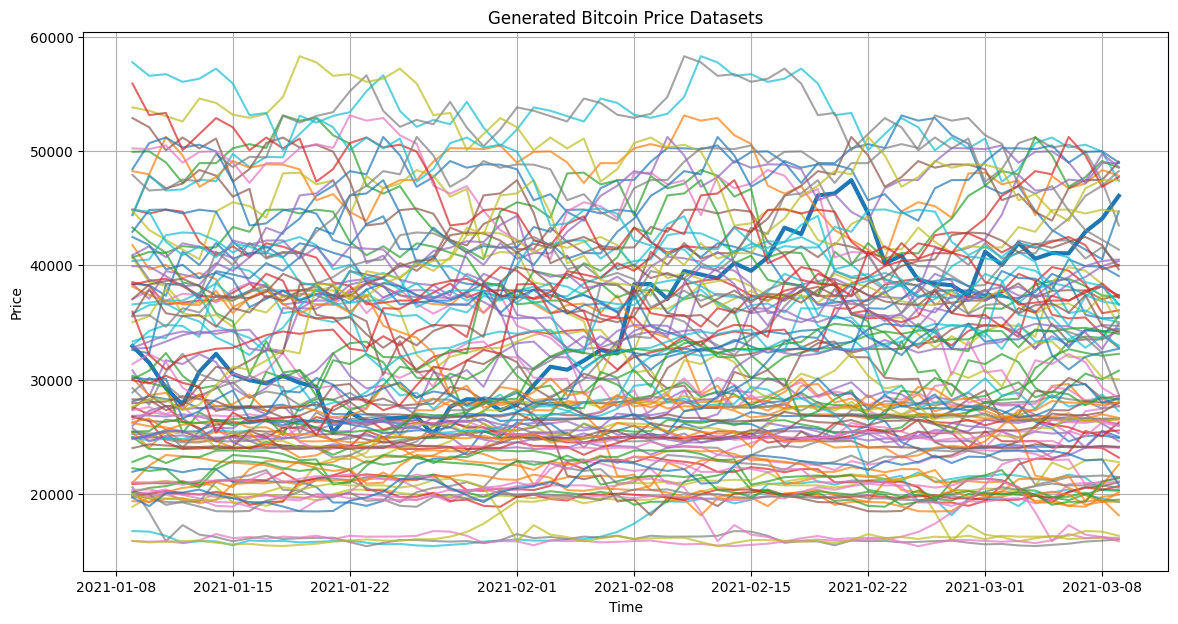

In [9]:
datasets = [periodi_casuali_esistenti[i]['Price'].values for i in range(len(periodi_casuali_esistenti))]

lunghezza_dataset = len(periodi_casuali_esistenti[0])

# Converte i dataset generati in DataFrame
generated_dfs = [pd.DataFrame({'Timestamp': dati['Timestamp'].iloc[:lunghezza_dataset], 'Price': prices}) for prices in datasets] # Fingo che le date siano tutte iniziate con data_inizio

# Plotting
plt.figure(figsize=(14, 7))

# Plot del dataset originale
plt.plot(dati['Timestamp'].iloc[:lunghezza_dataset], dati['Price'].iloc[:lunghezza_dataset].values, label='Original', linewidth=3)

# Plot dei dataset generati
for i, df in enumerate(generated_dfs):
    plt.plot(df['Timestamp'], df['Price'], label=f'Generated Dataset {i+1}', alpha=0.7)

plt.title('Generated Bitcoin Price Datasets')
plt.xlabel('Time')
plt.ylabel('Price')
# plt.yscale('log')
plt.grid()
# plt.legend()
plt.show()

In [10]:
dati_da_usare = periodi_casuali_esistenti.copy()

## Grid search

In [11]:
# from joblib import Parallel, delayed
# import pandas as pd
# import numpy as np

# def esegui_combinazione(ind, params, dati_da_usare, strategia, nomi_parametri_variabili, parametri_fissi, ideal_returns, target):
#     """
#     Esegue una singola combinazione di parametri per la grid search e restituisce i risultati.
#     """
#     parametri_e_valori = [nomi_parametri_variabili[j] + "=" + str(params[j]) for j in range(len(nomi_parametri_variabili))]
#     print(f"Sto calcolando la combinazione {ind+1} ({parametri_e_valori})...")

#     # Lista per conservare i rendimenti per ogni dataset
#     total_return_factors = []

#     for i, df in enumerate(dati_da_usare):
#         transactions = strategia(df, **{**dict(zip(nomi_parametri_variabili, params)), **parametri_fissi})
#         portfolio_values = transactions['valore_totale_portafoglio']
#         total_return_factor = portfolio_values.iloc[-1] / portfolio_values[0]
#         total_return_factors.append(total_return_factor)

#     rendimento_medio = np.mean(total_return_factors)
#     punteggio_rendimento_medio = np.mean([trf / ir for trf, ir in zip(total_return_factors, ideal_returns)])

#     # Restituisci i risultati
#     return {
#         **dict(zip(nomi_parametri_variabili, params)),
#         'rendimento_medio': rendimento_medio,
#         'punteggio_rendimento_medio': punteggio_rendimento_medio
#     }

# def grid_search_trading_strategy_parallel(dati_da_usare, strategia, param_combinations, nomi_parametri_variabili, parametri_fissi, ind_partenza, ind_fine, target, n_jobs=-1):
#     """
#     Esegue una grid search parallela su una strategia di trading.
#     """
#     total_combinations = len(param_combinations)

#     # Calcola i rendimenti ideali per ogni dataset
#     ideal_returns = [calcola_rendimento_portafoglio_ideale(df['Price'], *[parametri_fissi[chiave] for chiave in parametri_fissi.keys()])[0] for df in dati_da_usare]

#     # Usa joblib.Parallel per eseguire la grid search in parallelo
#     risultati = Parallel(n_jobs=n_jobs)(
#         delayed(esegui_combinazione)(ind, params, dati_da_usare, strategia, nomi_parametri_variabili, parametri_fissi, ideal_returns, target)
#         for ind, params in enumerate(param_combinations[ind_partenza-1:ind_fine])
#     )

#     # Converte i risultati in DataFrame e ordina
#     grid_search_results_df = pd.DataFrame(risultati)
#     sorted_results_df = grid_search_results_df.sort_values(by=target, ascending=False)

#     return sorted_results_df

In [12]:
# Configura il percorso di Tesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'  # Aggiorna con il percorso esatto

# Funzione per aprire WhatsApp Desktop installato dal Microsoft Store
def apri_whatsapp_desktop():
    # Usa il protocollo URI per aprire WhatsApp Desktop
    subprocess.run(['start', 'whatsapp://'], shell=True)
    time.sleep(8)  # Attendi qualche secondo per permettere all'app di aprirsi

# Funzione per inviare un messaggio e poi trovare di nuovo la posizione della chat
def invia_messaggio_whatsapp(contatto, messaggio):
    # Trova la barra di ricerca
    pag.hotkey('ctrl', 'f')  # Usa il comando per cercare un contatto
    time.sleep(1)

    # Scrivi il nome del contatto
    pag.write(contatto)
    time.sleep(2)  # Pausa per permettere il caricamento della lista di risultati

    # Cattura uno screenshot dell'area della lista delle chat
    left, top, right, bottom = 100, 200, 800, 600  # Regola le coordinate dell'area corretta
    screenshot = ImageGrab.grab(bbox=(left, top, right, bottom))  # Cattura l'area specifica

    # Preprocessing: Converti l'immagine in scala di grigi e migliora il contrasto
    gray_image = ImageOps.grayscale(screenshot)
    enhancer = ImageEnhance.Contrast(gray_image)
    enhanced_image = enhancer.enhance(2)  # Aumenta il contrasto per migliorare l'OCR

    # Usa pytesseract per ottenere i dati del testo, inclusi i bounding box
    data = pytesseract.image_to_data(enhanced_image, output_type=pytesseract.Output.DICT)

    # Cerca il contatto nei dati estratti
    # trovato = False
    for i in range(len(data['text'])):
        testo = data['text'][i].strip()
        if testo == contatto:
            # Calcola la posizione assoluta del bounding box sullo schermo
            x = left + data['left'][i] + data['width'][i] // 2
            y = top + data['top'][i] + data['height'][i] // 2

            # Clicca sulla posizione del contatto
            pag.click(x, y)
            time.sleep(1)

            # Copia il messaggio negli appunti e incollalo nella chat
            pyperclip.copy(messaggio)
            pag.hotkey('ctrl', 'v')  # Incolla il messaggio
            time.sleep(1)

            # Premi invio per inviare il messaggio
            pag.press('enter')
            time.sleep(1)

            # trovato = True
            break

    # if not trovato:
    #     raise ValueError(f"Non è stato possibile trovare la chat con il contatto {contatto}.")

    # Dopo l'invio del messaggio, la chat si sposta, quindi dobbiamo rifare l'OCR
    time.sleep(2)  # Pausa per permettere il riordinamento delle chat
    screenshot_after_send = ImageGrab.grab(bbox=(left, top, right, bottom))

    # Pre-elaborazione per migliorare la qualità dell'immagine (come prima)
    gray_image_after_send = ImageOps.grayscale(screenshot_after_send)
    enhancer_after_send = ImageEnhance.Contrast(gray_image_after_send)
    enhanced_image_after_send = enhancer_after_send.enhance(2)

    # Riconosci nuovamente il testo
    data_after_send = pytesseract.image_to_data(enhanced_image_after_send, output_type=pytesseract.Output.DICT)

    # trovato_dopo_invio = False
    for i in range(len(data_after_send['text'])):
        testo = data_after_send['text'][i].strip()
        if testo == contatto:
            # Calcola la nuova posizione della chat
            new_x = left + data_after_send['left'][i] + data_after_send['width'][i] // 2
            new_y = top + data_after_send['top'][i] + data_after_send['height'][i] // 2

            # Click destro sulla nuova posizione della chat
            pag.rightClick(new_x, new_y)
            time.sleep(1)

            # Click sulla prima voce del menu a tendina (Segna come da leggere)
            pag.click(new_x + 50, new_y + 30)
            # time.sleep(1)
            pag.click(new_x + 50, new_y + 30) # Non so perchè ma devo cliccare una seconda volta col sinistro, solo il primo non funziona

            # trovato_dopo_invio = True
            break

    # if not trovato_dopo_invio:
    #     raise ValueError(f"Non è stato possibile trovare nuovamente la chat con il contatto {contatto} dopo l'invio del messaggio.")

In [13]:
def grid_search_trading_strategy(dati_da_usare, strategia, param_combinations, nomi_parametri_variabili, parametri_fissi, ind_partenza, ind_fine, condizioni_salto, target, whatsapp, calcola_metriche_performance):
    """
    Esegue una grid search su una strategia di trading, trovando la migliore combinazione di parametri
    che massimizza un target specifico (rendimento_medio o punteggio_rendimento_medio).
    
    Args:
        dati_da_usare (list): Lista di DataFrame contenenti i dati di prezzo per i vari periodi.
        strategia (function): Strategia di trading da ottimizzare.
        param_combinations (list): Lista delle combinazioni di parametri da testare (ottenuta con itertools.product).
        parametri_fissi (dict, optional): Dizionario di parametri fissi da passare alla strategia. Default è None.
        ind_partenza (int, optional): Indice di partenza per la grid search. Default è 1.
        ind_fine (int, optional): Indice di fine per la grid search. Default è la lunghezza delle combinazioni di parametri.
        target (str, optional): Target da massimizzare ('rendimento_medio' o 'punteggio_rendimento_medio'). Default è 'punteggio_rendimento_medio'.
    
    Returns:
        pd.DataFrame: DataFrame ordinato contenente i risultati della grid search.
    """
    # if parametri_fissi is None:
    #     parametri_fissi = {}

    total_combinations = len(param_combinations)

    # if ind_fine is None:
    #     ind_fine = total_combinations
    
    # Calcola i rendimenti ideali per ogni dataset
    ideal_returns = [calcola_rendimento_portafoglio_ideale(df['Price'], *[parametri_fissi[chiave] for chiave in parametri_fissi.keys()])[0] for df in dati_da_usare]

    # Inizializza variabili per tenere traccia delle coppie migliori e peggiori
    best_pair = {'score': -np.inf, 'total_return_factor': -np.inf, 'dataset': None, 'params': None, 'transactions': None}
    worst_pair = {'score': np.inf, 'total_return_factor': np.inf, 'dataset': None, 'params': None, 'transactions': None}

    best_value = -np.inf
    combinazione_max = None
    grid_search_results = []
    list_transactions = []

    saltate = 0
    calcolate = 0

    # Inizia la grid search
    for ind, params in enumerate(param_combinations):
        if ind_partenza <= ind + 1 <= ind_fine:
            parametri_e_valori = [nomi_parametri_variabili[j] + "=" + str(params[j]) for j in range(len(nomi_parametri_variabili))]

            # Verifica se saltare la combinazione
            if condizioni_salto[ind]:
                print(f'Salto la combinazione {ind+1}/{total_combinations} ({parametri_e_valori}) perchè sarebbe identica a una combinazione già vista...\n')
                saltate += 1
                continue

            print(f"Sto calcolando la combinazione {ind+1}/{total_combinations} ({parametri_e_valori}) ({calcolate} calcolate, {saltate} saltate)...")
            calcolate += 1
            
            # Lista per conservare i rendimenti per ogni dataset
            total_return_factors = []

            for i, df in enumerate(dati_da_usare):
                transactions = strategia(df, **{**dict(zip(nomi_parametri_variabili, params)), **parametri_fissi})
                portfolio_values = transactions['valore_totale_portafoglio']
                total_return_factor = portfolio_values.iloc[-1] / portfolio_values[0]
                total_return_factors.append(total_return_factor)
                if calcola_metriche_performance:
                    list_transactions.append([transactions['valore_totale_portafoglio'], transactions['prezzo'], transactions['bitcoin']])
                
                # punteggio_rendimento = total_return_factor / ideal_returns[i]
                
                # Gestisci il best/worst se necessario (facoltativo)
                # Calcola il punteggio rendimento
                punteggio_rendimento = total_return_factor / ideal_returns[i]
                # Aggiorna la coppia migliore e peggiore
                if punteggio_rendimento > best_pair['score']:
                    best_pair = {'score': punteggio_rendimento, 'total_return_factor': total_return_factor, 'dataset': i, 'params': parametri_e_valori, 'transactions': transactions}
                if punteggio_rendimento < worst_pair['score']:
                    worst_pair = {'score': punteggio_rendimento, 'total_return_factor': total_return_factor, 'dataset': i, 'params': parametri_e_valori, 'transactions': transactions}

            rendimento_medio = np.mean(total_return_factors)
            punteggio_rendimento_medio = np.mean([trf / ir for trf, ir in zip(total_return_factors, ideal_returns)])
            std_punteggi = np.std([trf / ir for trf, ir in zip(total_return_factors, ideal_returns)])
            
            # Salva i risultati
            grid_search_results.append({
                **dict(zip(nomi_parametri_variabili, params)),
                'rendimento_medio': rendimento_medio,
                'punteggio_rendimento_medio': punteggio_rendimento_medio,
                'deviazione_standard_punteggi': std_punteggi
            })

            print(f'Fattore Rendimento Medio: {rendimento_medio}')
            print(f'Punteggio rendimento medio: {punteggio_rendimento_medio}')
            print(f'Deviazione standard dei punteggi ottenuti sui vari dataset: {std_punteggi}')

            if calcola_metriche_performance:                
                # Calcolo delle metriche di performance per ogni dataset usando le funzioni della libreria 'mdp'
                media_max_drawdown = np.mean([mdp.max_drawdown(trans[0]) for trans in list_transactions])
                media_volatilita = np.mean([mdp.volatility(trans[0]) for trans in list_transactions])
                media_sharpe_ratio = np.mean([mdp.sharpe_ratio(trans[0]) for trans in list_transactions])
                media_sortino_ratio = np.mean([mdp.sortino_ratio(trans[0]) for trans in list_transactions])
                media_calmar_ratio = np.mean([mdp.calmar_ratio(trans[0]) for trans in list_transactions])
                media_profit_factor = np.mean([mdp.profit_factor(trans[1], trans[2]) for trans in list_transactions])
                media_pnl_per_trade = np.mean([np.mean(mdp.calcola_pnl(trans[1], trans[2])) for trans in list_transactions])

                # Stampa delle metriche calcolate
                print(f'Media max drawdown: {media_max_drawdown:.2f}%')
                print(f'Media volatilità: {media_volatilita:.2f}')
                print(f'Media Sharpe ratio: {media_sharpe_ratio:.2f}')
                print(f'Media Sortino ratio: {media_sortino_ratio:.2f}')
                print(f'Media Calmar ratio: {media_calmar_ratio:.2f}')
                print(f'Media Profit factor: {media_profit_factor:.2f}')
                print(f'Media PnL per trade: {media_pnl_per_trade:.2f}')

            
            # Aggiorna il valore massimo
            current_value = punteggio_rendimento_medio if target == 'punteggio_rendimento_medio' else rendimento_medio
            if current_value > best_value:
                best_value = current_value
                alternative_value = rendimento_medio if target == 'punteggio_rendimento_medio' else punteggio_rendimento_medio
                combinazione_max = parametri_e_valori
                ind_max = ind
                if whatsapp:
                    try:
                        apri_whatsapp_desktop()
                        contatto = "(tu)"  # Cambiare con il nome del contatto come appare su WhatsApp
                        messaggio = f"Ho trovato un nuovo punteggio! Il suo indice è {ind_max}, con un punteggio di {best_value}, corrispondente alla combinazione {combinazione_max}"
                        invia_messaggio_whatsapp(contatto, messaggio)
                    except Exception as e:
                        print("C'è stato qualche problema con l'invio del messaggio WhatsApp... errore:", e)
            
            if target == 'punteggio_rendimento_medio':
                print(f'Punteggio rendimento medio migliore trovato finora (combinazione {ind_max+1}): {best_value}, con fattore rendimento medio {alternative_value} e parametri {combinazione_max}\n')
            else:
                print(f'Fattore rendimento medio migliore trovato finora (combinazione {ind_max+1}): {best_value}, con punteggio rendimento medio {alternative_value} e parametri {combinazione_max}\n')

    # Converte i risultati in DataFrame e ordina
    grid_search_results_df = pd.DataFrame(grid_search_results)
    sorted_results_df = grid_search_results_df.sort_values(by=target, ascending=False)
    
    return sorted_results_df, best_pair, worst_pair

#### Grid search su media pesata forzata dinamica

In [14]:
# def strategia_media_pesata_forzata_dinamica(dati, liquidita_mobile_iniziale, liquidita_fissa_iniziale, bitcoin_iniziali, perc_commissione_acquisto, perc_commissione_vendita, min_acquisto, min_vendita, perc_primo_acquisto, vendita_immediata, perc_sbilanciamento_acquisto, soglia_minima_acquisto, soglia_minima_vendita, perc_stop_loss, compra_pure, vendita_immediata_dinamica, tempo_rsi, soglia_rsi, metodo, tempo_salite_discese_consecutive, soglia_salite_consecutive, coefficienti_acquisto):

#     liquidita_mobile = liquidita_mobile_iniziale
#     liquidita_fissa = liquidita_fissa_iniziale
#     bitcoin = bitcoin_iniziali

#     ultima_azione_effettiva = None
#     ultimi_acquisti = []
#     transazioni = pd.DataFrame(columns=['Data', 'Numero giorno', 'Prezzo', 'Ultima Azione', 'Azione Attuale', '% acquisto/vendita di LM', 'Quantità in € Comprata/Venduta', 'Quantità di Bitcoin Comprati/Venduti', 'Liquidità Mobile', 'Liquidità Fissa', 'Bitcoin Posseduti', 'Valore Totale del Portafoglio'])
#     giorni_acquisto = []
#     giorni_vendita = []

#     prezzo_massimo = 0
#     in_salita = False

#     def aggiorna_transazioni(i, azione, perc, quantita_euro, quantita_btc):
#         nonlocal transazioni, liquidita_mobile, liquidita_fissa, bitcoin, ultima_azione_effettiva # La parola chiave nonlocal viene utilizzata per dichiarare che una variabile all'interno di una funzione nidificata (una funzione definita all'interno di un'altra funzione) si riferisce a una variabile definita nel contesto della funzione esterna (non globale, ma nemmeno locale alla funzione corrente); dovrei usare invece "global" se questa function fosse definita a livello globale e non all'interno di un'altra function
#         ultima_azione = ultima_azione_effettiva if ultima_azione_effettiva else "-"
#         nuova_transazione = pd.DataFrame({
#             'Data': [dati['Timestamp'].iloc[i]],
#             'Numero giorno': i,
#             'Prezzo': [dati['Price'].iloc[i]],
#             'Ultima Azione': [ultima_azione],
#             'Azione Attuale': [azione],
#             '% acquisto/vendita di LM': [perc],
#             'Quantità in € Comprata/Venduta': [quantita_euro],
#             'Quantità di Bitcoin Comprati/Venduti': [quantita_btc],
#             'Liquidità Mobile': [liquidita_mobile],
#             'Liquidità Fissa': [liquidita_fissa],
#             'Bitcoin Posseduti': [bitcoin],
#             'Valore Totale del Portafoglio': [liquidita_mobile + liquidita_fissa + bitcoin * dati['Price'].iloc[i]]
#         })
#         transazioni = pd.concat([transazioni, nuova_transazione], ignore_index=True)
#         if azione != "-":
#             ultima_azione_effettiva = azione

#     def primo_acquisto(i):
#         nonlocal liquidita_mobile, bitcoin, ultimi_acquisti
#         quantita_primo_acquisto = liquidita_mobile * perc_primo_acquisto
#         bitcoin_acquistati = quantita_primo_acquisto / dati['Price'].iloc[i] * (1 - perc_commissione_acquisto)
#         liquidita_mobile -= quantita_primo_acquisto
#         bitcoin += bitcoin_acquistati
#         ultimi_acquisti = [(dati['Price'].iloc[i], quantita_primo_acquisto)]
#         giorni_acquisto.append(i)
#         aggiorna_transazioni(i, 'Primo Acquisto', perc_primo_acquisto, quantita_primo_acquisto, bitcoin_acquistati)

#     def calcola_prezzo_medio_pesato():
#         return sum([euro*prezzo for prezzo, euro in ultimi_acquisti]) / sum([euro for _ , euro in ultimi_acquisti])
    
#     def calculate_rsi(prices):
#         if len(prices) < 2:
#             raise ValueError("La lista dei prezzi deve contenere almeno 2 elementi per calcolare l'RSI.")

#         # Calcola le variazioni di prezzo
#         price_changes = [prices.iloc[k] - prices.iloc[k-1] for k in range(1, len(prices))]
        
#         # Separa i guadagni e le perdite
#         gains = [max(change, 0) for change in price_changes]
#         losses = [abs(min(change, 0)) for change in price_changes]

#         # Calcola la media dei guadagni e delle perdite
#         avg_gain = sum(gains) / len(gains) if len(gains) != 0 else 0
#         avg_loss = sum(losses) / len(losses) if len(losses) != 0 else 0

#         rsi = 100 * avg_gain / (avg_gain + avg_loss)

#         return rsi

#     def lunghezza_media_salite_discese_consecutive(prices):
#         if len(prices) < 1:
#             raise ValueError("La lista dei prezzi deve contenere almeno 1 elemento per calcolare il numero medio di salite e discese consecutive.")

#         up_lengths = []
#         down_lengths = []

#         current_trend = None
#         count = 0

#         for i in range(1, len(prices)):
#             if prices.iloc[i] > prices.iloc[i-1]:  # Salita
#                 if current_trend == 'up':
#                     count += 1
#                 else:
#                     if current_trend == 'down':
#                         down_lengths.append(count)
#                     current_trend = 'up'
#                     count = 1
#             elif prices.iloc[i] < prices.iloc[i-1]:  # Discesa
#                 if current_trend == 'down':
#                     count += 1
#                 else:
#                     if current_trend == 'up':
#                         up_lengths.append(count)
#                     current_trend = 'down'
#                     count = 1

#         # Aggiungi l'ultima sequenza
#         if current_trend == 'up':
#             up_lengths.append(count)
#         elif current_trend == 'down':
#             down_lengths.append(count)

#         return np.mean(up_lengths) if not np.isnan(np.mean(up_lengths)) else 0, np.mean(down_lengths) if not np.isnan(np.mean(down_lengths)) else 0


#     def mappatura_perc_primo_acquisto(lunghezza_media_discese, coefficienti_acquisto):
#         # perc_prima_vendita_risultante = sum(coefficienti_acquisto[i] * lunghezza_media_salite ** i for i in range(len(coefficienti_acquisto)))
#         perc_primo_acquisto_risultante = sum(coefficienti_acquisto[i] * lunghezza_media_discese ** i for i in range(len(coefficienti_acquisto)))

#         # if lunghezza_media_salite == 0:
#         #     perc_prima_vendita_risultante = 1
#         # else:
#         #     perc_prima_vendita_risultante = 2**(-lunghezza_media_salite+1)

#         # if lunghezza_media_discese == 0:
#         #     perc_primo_acquisto_risultante = 1
#         # else:
#         #     perc_primo_acquisto_risultante = 2**(-lunghezza_media_discese+1)

#         return min(1, perc_primo_acquisto_risultante)

#     # Primo acquisto al giorno 1
#     primo_acquisto(1)

#     for i in range(2, len(dati)):
#         if vendita_immediata_dinamica:
#             if metodo == 'rsi':
#                 if i < tempo_rsi:
#                     dati_parziali = dati[:i]
#                 else:
#                     dati_parziali = dati[i-tempo_rsi:i]

#                 rsi = calculate_rsi(dati_parziali['Price'])

#                 if rsi > soglia_rsi:
#                     vendita_immediata = False
#                 else:
#                     vendita_immediata = True
#             elif metodo == 'salite_discese_consecutive':
#                 if i < tempo_salite_discese_consecutive:
#                     dati_parziali = dati[:i]
#                 else:
#                     dati_parziali = dati[i-tempo_salite_discese_consecutive:i]

#                 salite_discese_consecutive = lunghezza_media_salite_discese_consecutive(dati_parziali['Price'])
#                 lunghezza_media_salite = salite_discese_consecutive[0]
#                 lunghezza_media_discese = salite_discese_consecutive[1]

#                 perc_primo_acquisto = mappatura_perc_primo_acquisto(lunghezza_media_discese, coefficienti_acquisto)

#                 if lunghezza_media_salite > soglia_salite_consecutive:
#                     vendita_immediata = False
#                 else:
#                     vendita_immediata = True

#                 # if lunghezza_media_discese > soglia_discese_consecutive:
#                 #         _ , perc_primo_acquisto = mappatura_perc_primo_acquisto(lunghezza_media_salite, lunghezza_media_discese, coefficienti_acquisto, coefficienti_vendita)

#             else:
#                 raise ValueError("Metodo scelto non valido")


#         prezzo_oggi = dati['Price'].iloc[i]
#         prezzo_ieri = dati['Price'].iloc[i-1]
#         prezzo_laltro_ieri = dati['Price'].iloc[i-2]
#         azione = "-"  # Inizializziamo l'azione come nulla
        
#         if bitcoin > 0:
#             prezzo_medio_pesato = calcola_prezzo_medio_pesato()
            
#             # Aggiorna il prezzo massimo se siamo in una salita
#             if prezzo_oggi > prezzo_ieri:
#                 in_salita = True
#                 if prezzo_ieri < prezzo_laltro_ieri:
#                     prezzo_massimo = 0  # Reset del prezzo massimo se il giorno precedente è finita una discesa
#                 prezzo_massimo = max(prezzo_massimo, prezzo_oggi)
#             else:
#                 in_salita = False
            
#             if vendita_immediata:
#                 if prezzo_oggi > prezzo_medio_pesato * (1 + soglia_minima_vendita):
#                     # Vendita immediata
#                     quantita_venduta = bitcoin
#                     ricavo = quantita_venduta * prezzo_oggi * (1 - perc_commissione_vendita)
#                     if ricavo >= min_vendita:
#                         liquidita_mobile += ricavo
#                         bitcoin = 0
#                         giorni_vendita.append(i)
#                         azione = 'Vendita'
#                         aggiorna_transazioni(i, azione, 1, ricavo, quantita_venduta)
#                         # print(sum([b for _, b in ultimi_acquisti]), ricavo, ricavo/sum([b for _, b in ultimi_acquisti]))
#                         ultimi_acquisti = []
#             else:
#                 if not in_salita and prezzo_oggi <= prezzo_massimo * (1 - perc_stop_loss) and prezzo_oggi > prezzo_medio_pesato * (1 + soglia_minima_vendita):
#                     # Vendita con stop-loss
#                     quantita_venduta = bitcoin
#                     ricavo = quantita_venduta * prezzo_oggi * (1 - perc_commissione_vendita)
#                     if ricavo >= min_vendita:
#                         liquidita_mobile += ricavo
#                         bitcoin = 0
#                         giorni_vendita.append(i)
#                         azione = 'Vendita (Stop-Loss)'
#                         aggiorna_transazioni(i, azione, 1, ricavo, quantita_venduta)
#                         # print(sum([b for _, b in ultimi_acquisti]), ricavo, ricavo/sum([b for _, b in ultimi_acquisti]), bitcoin*dati['Price'].iloc[i] + liquidita_mobile + liquidita_fissa)
#                         ultimi_acquisti = []
        
#         if azione != 'Vendita' and azione != 'Vendita (Stop-Loss)':  # Se non abbiamo venduto, consideriamo l'acquisto
#             if not ultimi_acquisti:
#                 if prezzo_oggi < prezzo_ieri:
#                     # Primo acquisto dopo una vendita
#                     primo_acquisto(i)
#                     azione = 'Primo Acquisto'
#                     # prezzo_massimo = prezzo_oggi  # Inizializzo il prezzo massimo
#             elif prezzo_oggi < ultimi_acquisti[-1][0] * (1 - soglia_minima_acquisto):
#                 # Calcolo del prezzo desiderato di acquisto
#                 ultimo_prezzo_acquisto = ultimi_acquisti[-1][0]
#                 A = perc_sbilanciamento_acquisto * prezzo_oggi + (1 - perc_sbilanciamento_acquisto) * ultimo_prezzo_acquisto # Prezzo a cui si vuole imporre la media pesata

#                 # Calcolo della quantità da acquistare
#                 S = sum([p * q for p, q in ultimi_acquisti])  # Questa è la somma pesata degli ultimi acquisti
#                 P = sum([q for _, q in ultimi_acquisti])  # Questa è la somma delle spese degli ultimi acquisti, cioè la somma dei pesi
#                 quantita_da_acquistare_euro = (S - A * P) / (A - prezzo_oggi)

#                 if quantita_da_acquistare_euro >= min_acquisto:
#                     if quantita_da_acquistare_euro > liquidita_mobile:
#                         # Usa la liquidità fissa se necessario
#                         liquidita_aggiuntiva = min(liquidita_fissa, quantita_da_acquistare_euro - liquidita_mobile)
#                         liquidita_mobile += liquidita_aggiuntiva
#                         liquidita_fissa -= liquidita_aggiuntiva

#                     if quantita_da_acquistare_euro <= liquidita_mobile:
#                         # Acquisto
#                         bitcoin_acquistati = quantita_da_acquistare_euro / prezzo_oggi * (1 - perc_commissione_acquisto)
#                         vecchia_liquidita_mobile = liquidita_mobile
#                         liquidita_mobile -= quantita_da_acquistare_euro
#                         bitcoin += bitcoin_acquistati
#                         ultimi_acquisti.append((prezzo_oggi, quantita_da_acquistare_euro))  # Ora memorizzo gli euro spesi invece dei bitcoin acquistati
#                         giorni_acquisto.append(i)
#                         azione = 'Acquisto'
#                         aggiorna_transazioni(i, azione, quantita_da_acquistare_euro / vecchia_liquidita_mobile, quantita_da_acquistare_euro, bitcoin_acquistati)

#                     elif quantita_da_acquistare_euro > liquidita_mobile and compra_pure and liquidita_mobile != 0:
#                         # Acquisto con tutto quello che rimane nella liquidità mobile anche se non viene rispettata la percentuale di sbilanciamento richiesta
#                         bitcoin_acquistati = liquidita_mobile / prezzo_oggi * (1 - perc_commissione_acquisto)
#                         vecchia_liquidita_mobile = liquidita_mobile
#                         liquidita_mobile = 0
#                         bitcoin += bitcoin_acquistati
#                         ultimi_acquisti.append((prezzo_oggi, vecchia_liquidita_mobile))  # Ora memorizzo gli euro spesi invece dei bitcoin acquistati
#                         giorni_acquisto.append(i)
#                         azione = 'Acquisto'
#                         aggiorna_transazioni(i, azione, 1, vecchia_liquidita_mobile, bitcoin_acquistati)
        
#         if azione == "-":
#             # Se non è stata effettuata nessuna azione, aggiungo comunque una riga alla tabella
#             aggiorna_transazioni(i, azione, 0, 0, 0)

#     return transazioni

In [15]:
# # Parametri da variare nella grid search
# perc_primo_acquisto_values = [0.1, 0.3, 0.5]
# vendita_immediata_values = [True, False]
# perc_sbilanciamento_acquisto_values = [0.5, 0.7, 0.9]
# soglia_minima_acquisto_values = [0, 0.05, 0.1]
# soglia_minima_vendita_values = [-0.3, 0, 0.3]
# perc_stop_loss_values = [0, 0.1, 0.2]
# compra_pure_values = [True, False]
# vendita_immediata_dinamica_values = [True, False] # Valutare se usare il numero medio di salite consecutive anzichè l'rsi
# tempo_rsi_values = [3, 7, 14]
# soglia_rsi_values = [25, 50, 75] # Percentuale già moltiplicata per 100, quindi è un numero da 0 a 100!
# metodo_values = ['rsi', 'salite_discese_consecutive']
# tempo_salite_discese_consecutive_values = [7, 14, 21]
# soglia_salite_consecutive_values = [1, 1.5, 2] # Numeri reali >= 1
# coefficienti_acquisto_values = [[1, 0.5, -0.625, 0.125], # mappa 0 in 1, 1 in 1, 2 in 0.5, 3 in 0.25
#                                 [0.5, 1.41667, -1.125, 0.208333], # mappa 0 in 0.5, 1 in 1, 2 in 0.5, 3 in 0.25
#                                  [0.5, 2.69129, -3.91627, 2.39463, -0.81746, 0.166656, -0.0201416, 0.00133076, -0.0000370086]] # mappa 0 in 0.5, 1 in 1, 2 in 0.5, 3 in 0.25, 4 in 0.125, 5 in 0.0625, 6 in 1/32, 7 in 1/64, 8 in 1/128

# lista_values = [perc_primo_acquisto_values, vendita_immediata_values, perc_sbilanciamento_acquisto_values, soglia_minima_acquisto_values, soglia_minima_vendita_values, perc_stop_loss_values, compra_pure_values, vendita_immediata_dinamica_values, tempo_rsi_values, soglia_rsi_values, metodo_values, tempo_salite_discese_consecutive_values, soglia_salite_consecutive_values, coefficienti_acquisto_values]

In [16]:
# # Definisci i parametri fissi
# parametri_fissi = {
#     'liquidita_mobile_iniziale': 1000,
#     'liquidita_fissa_iniziale': 0,
#     'bitcoin_iniziali': 0,
#     'perc_commissione_acquisto': 0.001,
#     'perc_commissione_vendita': 0.001,
#     'min_acquisto': 5,
#     'min_vendita': 5
# }

# # Genera tutte le combinazioni dei parametri variabili
# nomi_parametri_variabili = ['perc_primo_acquisto', 'vendita_immediata', 'perc_sbilanciamento_acquisto', 'soglia_minima_acquisto', 'soglia_minima_vendita', 
#                        'perc_stop_loss', 'compra_pure', 'vendita_immediata_dinamica', 'tempo_rsi', 'soglia_rsi', 'metodo', 
#                        'tempo_salite_discese_consecutive', 'soglia_salite_consecutive', 'coefficienti_acquisto']

# param_combinations = list(itertools.product(*lista_values))

# ind_partenza = 1
# ind_fine = len(param_combinations)

# # Creo la lista delle condizioni di salto, cioè dei booleani che mi dicono se saltare la combinazione perchè sarebbe uguale a una combinazione già vista
# condizioni_salto = []
# for ind, params in enumerate(param_combinations):
#             if ind_partenza <= ind + 1 <= ind_fine:
#                 perc_primo_acquisto, vendita_immediata, perc_sbilanciamento_acquisto, soglia_minima_acquisto, soglia_minima_vendita, perc_stop_loss, compra_pure, vendita_immediata_dinamica, tempo_rsi, soglia_rsi, metodo, tempo_salite_discese_consecutive, soglia_salite_consecutive, coefficienti_acquisto = params

#                 condizione = not vendita_immediata_dinamica and (tempo_rsi != tempo_rsi_values[0] or soglia_rsi != soglia_rsi_values[0] or metodo != metodo_values[0] or tempo_salite_discese_consecutive != tempo_salite_discese_consecutive_values[0] or soglia_salite_consecutive != soglia_salite_consecutive_values[0] or coefficienti_acquisto != coefficienti_acquisto_values[0]) or vendita_immediata_dinamica and vendita_immediata != vendita_immediata_values[0] or perc_primo_acquisto == 1 and (perc_sbilanciamento_acquisto != perc_sbilanciamento_acquisto_values[0] or soglia_minima_acquisto != soglia_minima_acquisto_values[0] or compra_pure != compra_pure_values[0]) or vendita_immediata and perc_stop_loss != perc_stop_loss_values[0] or metodo != 'salite_discese_consecutive' and (tempo_salite_discese_consecutive != tempo_salite_discese_consecutive_values[0] or soglia_salite_consecutive != soglia_salite_consecutive_values[0] or coefficienti_acquisto != coefficienti_acquisto_values[0])

#                 condizioni_salto.append(condizione)
#             else:
#                 condizioni_salto.append(None)         

# target = 'punteggio_rendimento_medio' # Scegliere tra rendimento_medio e fattore_rendimento_medio

# # Esegui la grid search
# sorted_results_df = grid_search_trading_strategy(dati_da_usare, strategia_media_pesata_forzata_dinamica, param_combinations, nomi_parametri_variabili, parametri_fissi, ind_partenza, ind_fine, condizioni_salto, target)

#### Grid search su trading a potenze con matrice

In [17]:
# def normalizza_matrice(matrice, exception_cells):
#     """
#     Normalizza una matrice tenendo conto delle celle da escludere.
#     """
#     # Creiamo una copia della matrice originale per evitare modifiche in-place
#     matrice = matrice.copy()
    
#     # Imposta a zero le celle in exception_cells
#     for cella in exception_cells:
#         matrice[cella[0], cella[1]] = 0

#     # Normalizza la matrice in modo che la somma delle celle sia 1
#     somma_totale = np.sum(matrice)
    
#     if somma_totale == 0:
#         raise ValueError("La somma delle celle nella matrice, escluse le eccezioni, è 0. Non è possibile normalizzare.")
    
#     matrice /= somma_totale
#     return matrice

# def trading_potenze_con_matrice(dati, righe, colonne, matrice_liquidità, matrice_bitcoin, exception_cells, giorni_ridistribuzione, base_acquisto, base_vendita, soglia_vendita, max_exp_acquisto, max_exp_vendita, riferimento_iniziale_acquisto, compra_pure, liquidità_iniziale, bitcoin_iniziali):
#     if not matrice_liquidità[0]:
#         matrice_liquidità = np.full((righe, colonne), 1 / (righe * colonne))

#     if not matrice_bitcoin[0]:
#         matrice_bitcoin = np.full((len(matrice_liquidità), len(matrice_liquidità[0])), 1 / (len(matrice_liquidità) *  len(matrice_liquidità[0])))

#     # Controllo sugli max_exp_acquisto e max_exp_vendita
#     if not (isinstance(max_exp_acquisto, int) and max_exp_acquisto <= 0):
#         raise ValueError("max_exp_acquisto deve essere un intero non positivo.")
#     if not (isinstance(max_exp_vendita, int) and max_exp_vendita <= 0):
#         raise ValueError("max_exp_vendita deve essere un intero non positivo.")
    
#     # Convertiamo i dati di input in numpy array per efficienza
#     matrice_liquidità = np.array(matrice_liquidità)
#     matrice_bitcoin = np.array(matrice_bitcoin)
    
#     # Controlli iniziali: Verifichiamo che la somma delle celle faccia 1
#     if not np.isclose(np.sum(matrice_liquidità), 1) or not np.isclose(np.sum(matrice_bitcoin), 1):
#         raise ValueError("Le matrici non sono normalizzate correttamente, la somma delle loro celle deve essere 1.")
    
#     if base_acquisto < 1 or base_vendita < 1:
#         raise ValueError("Attenzione! base_vendita e base_acquisto devono essere entrambi almeno 1.")
    
#     # Normalizzazione delle matrici se ci sono eccezioni
#     if exception_cells:
#         matrice_liquidità = normalizza_matrice(matrice_liquidità, exception_cells)
#         matrice_bitcoin = normalizza_matrice(matrice_bitcoin, exception_cells)
    
#     # Estrazione dei dati sui prezzi
#     prezzi = dati['Price'].values
#     date = dati['Timestamp'].values
    
#     # Inizializzo le quantità parziali di liquidità e bitcoin per ogni strategia
#     liquidità_parziale = matrice_liquidità * liquidità_iniziale
#     bitcoin_parziale = matrice_bitcoin * bitcoin_iniziali
    
#     # Mantengo una copia della liquidità dopo l'ultima ridistribuzione, se necessario
#     liquidità_iniziale_ridistribuzione = np.copy(liquidità_parziale) if riferimento_iniziale_acquisto else None
    
#     # DataFrame per tenere traccia delle transazioni giornaliere
#     transazioni_giornaliere = []
    
#     # Variabili per tenere traccia di stato acquisto/vendita per ogni strategia
#     acquisto_contatori = np.zeros_like(matrice_liquidità)
#     vendita_contatori = np.zeros_like(matrice_bitcoin)
#     prezzo_medio_acquisto = np.zeros_like(matrice_bitcoin)
#     euro_spesi_acquisto = np.zeros_like(matrice_bitcoin)  # Tieni traccia degli euro spesi durante l'ultima scia di acquisti
#     in_scia_acquisto = np.zeros_like(matrice_bitcoin, dtype=bool)  # Flag per indicare se siamo in una scia di acquisti
    
#     # Loop sui giorni
#     for giorno in range(1, len(prezzi)):  # Inizia da 1 perché confrontiamo con il giorno precedente
#         prezzo_corrente = prezzi[giorno]
#         prezzo_precedente = prezzi[giorno - 1]
        
#         # Calcolo la liquidità e i bitcoin totali all'inizio del giorno
#         liquidità_inizio_giorno = np.sum(liquidità_parziale)
#         bitcoin_inizio_giorno = np.sum(bitcoin_parziale)
        
#         # Variabili per tenere traccia delle transazioni giornaliere
#         euro_spesi_giorno = 0
#         euro_guadagnati_giorno = 0
#         bitcoin_guadagnati_giorno = 0
#         bitcoin_venduti_giorno = 0
        
#         # Loop su tutte le strategie
#         for i in range(matrice_liquidità.shape[0]):
#             for j in range(matrice_liquidità.shape[1]):
#                 if (i, j) in exception_cells:
#                     continue
                
#                 # Acquisto: Se il prezzo scende e ho liquidità
#                 if prezzo_corrente < prezzo_precedente:
#                     # Determina la liquidità di riferimento
#                     if riferimento_iniziale_acquisto:
#                         liquidità_riferimento = liquidità_iniziale_ridistribuzione[i, j]
#                     else:
#                         liquidità_riferimento = liquidità_parziale[i, j]
                    
#                     # Determina la percentuale di acquisto in base alla progressione geometrica
#                     percentuale_acquisto = min(base_acquisto ** max_exp_acquisto, base_acquisto ** (max_exp_acquisto - i + acquisto_contatori[i, j]))
#                     euro_da_spendere = percentuale_acquisto * liquidità_riferimento
                    
#                     # Se la liquidità da spendere è maggiore della liquidità attuale
#                     if euro_da_spendere > liquidità_parziale[i, j]:
#                         if compra_pure:
#                             euro_acquisto = liquidità_parziale[i, j]  # Spendi tutto quello che hai
#                         else:
#                             continue  # Non comprare niente
#                     else:
#                         euro_acquisto = euro_da_spendere
                    
#                     # Aggiorna liquidità e bitcoin
#                     liquidità_parziale[i, j] -= euro_acquisto
#                     bitcoin_acquistati = euro_acquisto / prezzo_corrente
#                     bitcoin_parziale[i, j] += bitcoin_acquistati
                    
#                     # Aggiorna il prezzo medio pesato degli acquisti solo per la scia corrente
#                     euro_spesi_acquisto[i, j] += euro_acquisto
#                     prezzo_medio_acquisto[i, j] = (
#                         prezzo_medio_acquisto[i, j] * (euro_spesi_acquisto[i, j] - euro_acquisto) + euro_acquisto * prezzo_corrente
#                     ) / euro_spesi_acquisto[i, j]
                    
#                     # Aggiorna il contatore degli acquisti e delle transazioni giornaliere
#                     acquisto_contatori[i, j] += 1
#                     euro_spesi_giorno += euro_acquisto
#                     bitcoin_guadagnati_giorno += bitcoin_acquistati
#                     vendita_contatori[i, j] = 0  # Reset contatore vendite per nuova discesa
                
#                 # Vendita: Se il prezzo sale e ho bitcoin
#                 elif prezzo_corrente > prezzo_precedente and bitcoin_parziale[i, j] > 0:
#                     # Verifica se il prezzo corrente supera il prezzo medio pesato dell'ultima scia di acquisti
#                     if prezzo_corrente > prezzo_medio_acquisto[i, j] * (1 + soglia_vendita):
#                         # Reset della scia di acquisti e inizio della scia di vendite
#                         in_scia_acquisto[i, j] = False

#                         percentuale_vendita = min(base_vendita ** max_exp_vendita, base_vendita ** (max_exp_vendita - j + vendita_contatori[i, j]))
#                         bitcoin_da_vendere = percentuale_vendita * bitcoin_parziale[i, j]
                        
#                         # Aggiorna bitcoin e liquidità
#                         bitcoin_parziale[i, j] -= bitcoin_da_vendere
#                         euro_venduti = bitcoin_da_vendere * prezzo_corrente
#                         liquidità_parziale[i, j] += euro_venduti
                        
#                         # Aggiorna le transazioni giornaliere
#                         euro_guadagnati_giorno += euro_venduti
#                         bitcoin_venduti_giorno += bitcoin_da_vendere
                        
#                         # Incrementa il contatore delle vendite
#                         vendita_contatori[i, j] += 1
#                         acquisto_contatori[i, j] = 0  # Reset contatore acquisti per nuova salita
        
#         # Calcolo le percentuali di liquidità e bitcoin usati per le transazioni
#         percentuale_liquidità_usata = euro_spesi_giorno / liquidità_inizio_giorno if liquidità_inizio_giorno > 0 else 0
#         percentuale_bitcoin_venduti = bitcoin_venduti_giorno / bitcoin_inizio_giorno if bitcoin_inizio_giorno > 0 else 0
        
#         # Calcolo il valore del portafoglio totale alla fine del giorno
#         valore_liquidità_totale = np.sum(liquidità_parziale)
#         numero_totale_bitcoin = np.sum(bitcoin_parziale)
#         valore_bitcoin_totale = numero_totale_bitcoin * prezzo_corrente
#         valore_totale_giornaliero = valore_liquidità_totale + valore_bitcoin_totale
        
#         # Salvo i dati delle transazioni giornaliere
#         transazioni_giornaliere.append({
#             'data': date[giorno],
#             'prezzo': prezzo_corrente,
#             'euro spesi': euro_spesi_giorno,
#             'euro guadagnati': euro_guadagnati_giorno,
#             'bitcoin venduti': bitcoin_venduti_giorno,
#             'bitcoin guadagnati': bitcoin_guadagnati_giorno,
#             'percentuale liquidità usata': percentuale_liquidità_usata,
#             'percentuale bitcoin venduti': percentuale_bitcoin_venduti,
#             'liquidità totale': valore_liquidità_totale,
#             'bitcoin totali': numero_totale_bitcoin,
#             'valore bitcoin totali': valore_bitcoin_totale,
#             'valore_totale_portafoglio': valore_totale_giornaliero
#         })
        
#         # Ogni "giorni_ridistribuzione" giorni, facciamo la ridistribuzione
#         if (giorno + 1) % giorni_ridistribuzione == 0:
#             # Somma totale di liquidità e bitcoin attuali
#             liquidità_totale = np.sum(liquidità_parziale)
#             bitcoin_totale = np.sum(bitcoin_parziale)
            
#             # Ridistribuisco la liquidità e i bitcoin parziali in base alle matrici
#             liquidità_parziale = matrice_liquidità * liquidità_totale
#             bitcoin_parziale = matrice_bitcoin * bitcoin_totale
            
#             # Se riferimento_iniziale_acquisto è True, aggiorno la liquidità di riferimento
#             if riferimento_iniziale_acquisto:
#                 liquidità_iniziale_ridistribuzione = np.copy(liquidità_parziale)

#     # Converto le transazioni giornaliere in un DataFrame
#     df_transazioni = pd.DataFrame(transazioni_giornaliere)
    
#     return df_transazioni

In [18]:
# righe_values = [3]
# colonne_values = [1]
# matrice_liquidità_values = [[[]]] # Per eventuali valori vuoti viene creata una matrice uniforme dall'algoritmo di trading (con dimensioni righe x colonne)
# matrice_bitcoin_values = [[[]]] # Per eventuali valori vuoti viene creata una matrice uniforme dall'algoritmo di trading (con dimensioni uguali a matrice_liquidità)
# exception_cells_values = [[(0, 0), (1, 0)]] # [[], [(0, 0)], [(0, 0), (1, 0)], [(1, 0)]] # Assicurarsi che esistano le celle indicate per tutte le combinazioni
# giorni_ridistribuzione_values = [7]
# base_acquisto_values = [1.004, 1.005, 1.006]
# base_vendita_values = [1.08]
# soglia_vendita_values = [-np.inf]
# max_exp_acquisto_values = [-2, -1, 0]
# max_exp_vendita_values = [-2, -1, 0]
# riferimento_iniziale_acquisto_values = [True, False]
# compra_pure_values = [True, False]

# lista_values = [righe_values, colonne_values, matrice_liquidità_values, matrice_bitcoin_values, exception_cells_values, giorni_ridistribuzione_values, base_acquisto_values, base_vendita_values, soglia_vendita_values, max_exp_acquisto_values, max_exp_vendita_values, riferimento_iniziale_acquisto_values, compra_pure_values]

In [19]:
# # Definisci i parametri fissi
# parametri_fissi = {
#     'liquidità_iniziale': 1000,
#     'bitcoin_iniziali': 0
# }

# # Genera tutte le combinazioni dei parametri variabili
# nomi_parametri_variabili = ['righe', 'colonne', 'matrice_liquidità', 'matrice_bitcoin', 'exception_cells', 'giorni_ridistribuzione', 'base_acquisto', 'base_vendita', 'soglia_vendita', 'max_exp_acquisto', 'max_exp_vendita', 'riferimento_iniziale_acquisto', 'compra_pure']

# param_combinations = list(itertools.product(*lista_values))

# ind_partenza = 1
# ind_fine = len(param_combinations)

# # Creo la lista delle condizioni di salto, cioè dei booleani che mi dicono se saltare la combinazione perchè sarebbe uguale a una combinazione già vista
# condizioni_salto = []
# for ind, params in enumerate(param_combinations):
#             if ind_partenza <= ind + 1 <= ind_fine:
#                 righe, colonne, matrice_liquidità, matrice_bitcoin, exception_cells, giorni_ridistribuzione, base_acquisto, base_vendita, soglia_vendita, max_exp_acquisto, max_exp_vendita, riferimento_iniziale_acquisto, compra_pure = params

#                 condizione = not riferimento_iniziale_acquisto and compra_pure != compra_pure_values[0] or matrice_liquidità[0] and (righe != righe_values[0] or colonne != colonne_values[0]) or matrice_bitcoin[0] and (righe != righe_values[0] or colonne != colonne_values[0])

#                 condizioni_salto.append(condizione)
#             else:
#                 condizioni_salto.append(None)         

# target = 'punteggio_rendimento_medio' # Scegliere tra rendimento_medio e punteggio_rendimento_medio

# # Esegui la grid search
# sorted_results_df, best_pair, worst_pair = grid_search_trading_strategy(dati_da_usare, trading_potenze_con_matrice, param_combinations, nomi_parametri_variabili, parametri_fissi, ind_partenza, ind_fine, condizioni_salto, target)

# # Punteggio rendimento medio migliore trovato finora (combinazione 14122): 0.5709639540097551, con fattore rendimento medio 1.0850697297685996 e parametri ['righe=3', 'colonne=1', 'matrice_liquidità=[[]]', 'matrice_bitcoin=[[]]', 'exception_cells=[(0, 0), (1, 0)]', 'giorni_ridistribuzione=7', 'base_acquisto=1.005', 'base_vendita=1.08', 'soglia_vendita=-inf', 'max_exp_acquisto=0', 'max_exp_vendita=-1', 'riferimento_iniziale_acquisto=True', 'compra_pure=False']

In [20]:
# def plot_transactions(df, transactions, title):
#     df['Timestamp'] = pd.to_datetime(df['Timestamp'])
#     transactions['data'] = pd.to_datetime(transactions['data'])
    
#     plt.figure(figsize=(20, 7))
#     plt.grid()
#     plt.plot(df['Timestamp'], df['Price'], label='Prezzi')
    
#     acquisti = transactions[transactions['euro spesi'] > 0]
#     vendite = transactions[transactions['euro guadagnati'] > 0]
    
#     # Calcolo delle dimensioni dei punti
#     max_acquisto = acquisti['euro spesi'].max()
#     max_vendita = vendite['euro guadagnati'].max()
    
#     def calcola_dimensione(quantita, max_quantita, min_size=20, max_size=200):
#         return min_size + (max_size - min_size) * (quantita / max_quantita)
    
#     # Rimuovi eventuali NaN o infiniti
#     # acquisti = acquisti.dropna(subset=['data', 'prezzo', 'quantità_euro'])
#     # vendite = vendite.dropna(subset=['data', 'prezzo', 'quantità_euro'])
    
#     dimensioni_acquisti = acquisti['euro spesi'].apply(lambda x: calcola_dimensione(x, max_acquisto))
#     dimensioni_vendite = vendite['euro guadagnati'].apply(lambda x: calcola_dimensione(x, max_vendita))
    
#     # Verifica che tutte le dimensioni siano corrette
#     assert len(acquisti['data']) == len(acquisti['prezzo']) == len(dimensioni_acquisti)
#     assert len(vendite['data']) == len(vendite['prezzo']) == len(dimensioni_vendite)
    
#     if not acquisti.empty:
#         plt.scatter(acquisti['data'], acquisti['prezzo'], 
#                     s=dimensioni_acquisti, 
#                     color='green', alpha=0.6, label='Acquisti')
    
#     if not vendite.empty:
#         plt.scatter(vendite['data'], vendite['prezzo'], 
#                     s=dimensioni_vendite, 
#                     color='red', alpha=0.6, label='Vendite')
    
#     plt.title(title)
#     plt.xlabel('data')
#     plt.ylabel('prezzo')
#     plt.legend()
#     plt.show()

In [21]:
# # Stampa e visualizza i risultati per la coppia migliore
# print("\nMiglior coppia:")
# print(f"Dataset: {best_pair['dataset']}")
# print(f"Parametri: {best_pair['params']}")
# print(f"Fattore di rendimento totale: {best_pair['total_return_factor']}")
# print(f"Punteggio: {best_pair['score']}")
# plot_transactions(dati_da_usare[best_pair['dataset']], best_pair['transactions'], 'Transazioni per la miglior coppia')
# print("\nElenco transazioni per la miglior coppia:")
# best_pair['transactions'][(best_pair['transactions']['euro spesi'] > 0) | (best_pair['transactions']['euro guadagnati'] > 0)]

In [22]:
# # Stampa e visualizza i risultati per la coppia peggiore
# print("\nPeggior coppia:")
# print(f"Dataset: {worst_pair['dataset']}")
# print(f"Parametri: {worst_pair['params']}")
# print(f"Fattore di rendimento totale: {worst_pair['total_return_factor']}")
# print(f"Punteggio: {worst_pair['score']}")
# plot_transactions(dati_da_usare[worst_pair['dataset']], worst_pair['transactions'], 'Transazioni per la peggior coppia')
# print("\nElenco transazioni per la peggior coppia:")
# worst_pair['transactions'][(worst_pair['transactions']['euro spesi'] > 0) | (worst_pair['transactions']['euro guadagnati'] > 0)]

#### Grid search su trading a % senza micro variazioni

In [23]:
# Funzione per calcolare l'ultimo prezzo di riferimento discesa
def calcola_prezzo_riferimento_discesa(dati, soglia_discesa):
    variazione_cumulata = 1
    cont = 0

    for j in range(len(dati), 0, -1):
        variazione_giorno_precedente = dati['Variazione'].iloc[j-1]

        if pd.isna(variazione_giorno_precedente):
            continue

        if variazione_giorno_precedente < 1:  # Prezzo in discesa
            variazione_cumulata = 1
            cont = 0
        else:
            variazione_cumulata *= variazione_giorno_precedente
            if variazione_cumulata != variazione_giorno_precedente:
                cont += 1
            if variazione_cumulata - 1 >= soglia_discesa:
                # Se la variazione supera la soglia, restituisci il riferimento
                if j + cont - 1 == len(dati) - 1:
                    # Se il riferimento è l'ultimo giorno, restituisci None
                    return None, None
                return dati['Timestamp'].iloc[j+cont-1], dati['Price'].iloc[j+cont-1]

    # Se non si è trovata una variazione che supera la soglia, ritorna il primo giorno
    return dati['Timestamp'].iloc[0], dati['Price'].iloc[0]

# Funzione per calcolare l'ultimo prezzo di riferimento salita
def calcola_prezzo_riferimento_salita(dati, soglia_salita):
    variazione_cumulata = 1
    cont = 0

    for j in range(len(dati), 0, -1):
        variazione_giorno_precedente = dati['Variazione'].iloc[j-1]

        if pd.isna(variazione_giorno_precedente):
            continue

        if variazione_giorno_precedente > 1:  # Prezzo in salita
            variazione_cumulata = 1
            cont = 0
        else:
            variazione_cumulata *= variazione_giorno_precedente
            if variazione_cumulata != variazione_giorno_precedente:
                cont += 1
            if 1 - variazione_cumulata >= soglia_salita:
                # Se la variazione supera la soglia o il prezzo di riferimento è superiore al prezzo attuale, restituisci il riferimento
                if j + cont - 1 == len(dati) - 1:
                    # Se il riferimento è l'ultimo giorno, restituisci None
                    return None, None
                return dati['Timestamp'].iloc[j+cont-1], dati['Price'].iloc[j+cont-1]

    # Se non si è trovata una variazione che supera la soglia, ritorna il primo giorno
    return dati['Timestamp'].iloc[0], dati['Price'].iloc[0]

def calcola_percentuale(variazione, coefficienti, A, B):
    if isinstance(coefficienti, list):
        # Se coefficienti è una lista, esegue la somma ponderata delle variazioni
        return min(max(sum([c * variazione ** i for i, c in enumerate(coefficienti)]), 0), 1)
    
    elif isinstance(coefficienti, str) and coefficienti != 'custom_exp':
        # Se coefficienti è una stringa, interpreta la stringa come una formula matematica
        # Sostituisci 'x' con il valore di variazione
        formula = coefficienti.replace('x', str(variazione))
        # Usa eval per calcolare il risultato
        try:
            risultato = eval(formula)
        except Exception as e:
            raise ValueError(f"Errore nell'interpretazione della formula: {e}")
        return min(max(risultato, 0), 1)
    
    elif coefficienti == 'custom_exp':
        return eval(f'variazione ** {A} / ({B} + (1 - {B}) * variazione ** {A})')
    
    else:
        raise TypeError("Il parametro 'coefficienti' deve essere una lista, una stringa o 'custom_exp'.")

In [24]:
# def trading_perc_senza_micro_variazioni(dati, inverti_riferimento_acquisto, inverti_riferimento_vendita, acquisto_rispetto_liquidità_iniziale, 
#      compra_pure, vendi_pure, soglia_vendita,  A_a, B_a, A_v, B_v, coefficienti_acquisto, coefficienti_vendita, 
#      compra_solo_in_discesa, vendi_solo_in_salita, soglia_acquisto_rispetto_riferimento, 
#      soglia_vendita_rispetto_riferimento, soglia_calcolo_variazioni_discesa, soglia_calcolo_variazioni_salita, liquidità_iniziale, bitcoin_iniziali):

#     # Parametri iniziali
#     liquidità = liquidità_iniziale
#     bitcoin = bitcoin_iniziali
#     valore_totale_portafoglio = liquidità + bitcoin * dati['Price'][0]

#     # Calcolo variazioni giornaliere
#     dati['Variazione'] = dati['Price'] / dati['Price'].shift(1)

#     # Inizializza il DataFrame delle transazioni
#     df_transazioni = pd.DataFrame(columns=['data', 'prezzo', 'variazione_giornaliera_prezzo_percentuale',
#                                            'timestamp_riferimento_discesa', 'prezzo_riferimento_discesa',
#                                            'variazione_rispetto_riferimento_discesa', 'timestamp_riferimento_salita',
#                                            'prezzo_riferimento_salita', 'variazione_rispetto_riferimento_salita',
#                                            'azione', 'percentuale_liquidità_usata', 'percentuale_bitcoin_usata',
#                                            'quantità_euro', 'bitcoin_acquistati_o_venduti', 'liquidità', 'bitcoin',
#                                            'valore_totale_portafoglio'])

#     # Variabili per tenere traccia degli acquisti consecutivi
#     acquisti_consecutivi = []
#     quantità_euro_totale = 0  # Somma totale degli euro spesi negli acquisti consecutivi

#     # Simulazione del trading giorno per giorno
#     for i in range(1, len(dati)):
#         data_odierna = dati['Timestamp'].iloc[i]
#         prezzo_attuale = dati['Price'].iloc[i]
#         variazione_giornaliera_prezzo_percentuale = (dati['Variazione'].iloc[i] - 1) * 100

#         # Calcola i prezzi di riferimento discesa e salita
#         timestamp_riferimento_discesa, prezzo_riferimento_discesa = calcola_prezzo_riferimento_discesa(dati.iloc[:i+1], soglia_calcolo_variazioni_discesa)
#         timestamp_riferimento_salita, prezzo_riferimento_salita = calcola_prezzo_riferimento_salita(dati.iloc[:i+1], soglia_calcolo_variazioni_salita)

#         # Scegli il prezzo di riferimento più recente (se esiste)
#         prezzo_riferimento = None
#         if prezzo_riferimento_discesa is not None and prezzo_riferimento_salita is not None:
#             if timestamp_riferimento_discesa > timestamp_riferimento_salita:
#                 prezzo_riferimento = prezzo_riferimento_discesa
#                 tipo_riferimento = 'discesa'
#             else:
#                 prezzo_riferimento = prezzo_riferimento_salita
#                 tipo_riferimento = 'salita'
#         elif prezzo_riferimento_discesa is not None:
#             prezzo_riferimento = prezzo_riferimento_discesa
#             tipo_riferimento = 'discesa'
#         elif prezzo_riferimento_salita is not None:
#             prezzo_riferimento = prezzo_riferimento_salita
#             tipo_riferimento = 'salita'

#         # Se nessun riferimento è disponibile, passa al giorno successivo
#         if prezzo_riferimento is None:
#             continue

#         # Variabili per tracciare l'azione e la transazione
#         azione = '-'
#         percentuale_liquidità_usata = 0
#         percentuale_bitcoin_usata = 0
#         euro_spesi_o_ricavati = 0
#         bitcoin_acquistati_o_venduti = 0

#         # Logica di acquisto o vendita in base al riferimento più recente
#         if tipo_riferimento == 'discesa':  # Logica di acquisto
#             if inverti_riferimento_acquisto:
#                 variazione_percentuale = (prezzo_attuale - prezzo_riferimento_discesa) / prezzo_attuale
#             else:
#                 variazione_percentuale = (prezzo_riferimento_discesa - prezzo_attuale) / prezzo_riferimento_discesa

#             percentuale_acquisto = calcola_percentuale(abs(variazione_percentuale), coefficienti_acquisto, A_a, B_a)
#             liquidità_usabile = liquidità_iniziale if acquisto_rispetto_liquidità_iniziale else liquidità
#             euro_da_spendere = liquidità_usabile * percentuale_acquisto

#             if euro_da_spendere > liquidità:
#                 if compra_pure:
#                     euro_da_spendere = liquidità  # Usa tutto
#                 else:
#                     euro_da_spendere = 0  # Non fare niente

#             if euro_da_spendere > 0 and (compra_solo_in_discesa and variazione_giornaliera_prezzo_percentuale < 0 or not compra_solo_in_discesa) and prezzo_attuale < prezzo_riferimento_discesa * (1 - soglia_acquisto_rispetto_riferimento):
#                 bitcoin_acquistati = euro_da_spendere / prezzo_attuale
#                 liquidità -= euro_da_spendere
#                 bitcoin += bitcoin_acquistati
#                 azione = 'Acquisto'
#                 percentuale_liquidità_usata = percentuale_acquisto
#                 euro_spesi_o_ricavati = euro_da_spendere
#                 bitcoin_acquistati_o_venduti = bitcoin_acquistati

#                 # Aggiungi questo acquisto alla lista degli acquisti consecutivi
#                 acquisti_consecutivi.append((prezzo_attuale, euro_da_spendere))
#                 quantità_euro_totale += euro_da_spendere

#         elif tipo_riferimento == 'salita':  # Logica di vendita
#             if inverti_riferimento_vendita:
#                 variazione_percentuale = (prezzo_riferimento_salita - prezzo_attuale) / prezzo_attuale
#             else:
#                 variazione_percentuale = (prezzo_attuale - prezzo_riferimento_salita) / prezzo_riferimento_salita

#             percentuale_vendita = calcola_percentuale(abs(variazione_percentuale), coefficienti_vendita, A_v, B_v)
#             bitcoin_da_vendere = bitcoin * percentuale_vendita

#             # Controllo del prezzo di vendita rispetto alla media pesata degli acquisti consecutivi
#             if acquisti_consecutivi:
#                 # Calcolo della media pesata dei prezzi di acquisto
#                 somma_pesata = sum(prezzo * euro for prezzo, euro in acquisti_consecutivi)
#                 media_pesata_acquisti = somma_pesata / quantità_euro_totale

#                 # Verifica che il prezzo attuale sia superiore alla soglia rispetto alla media pesata
#                 if prezzo_attuale <= media_pesata_acquisti * (1 + soglia_vendita):
#                     # Se non soddisfa la soglia di vendita, non fare niente
#                     bitcoin_da_vendere = 0

#             if bitcoin_da_vendere > bitcoin:
#                 if vendi_pure:
#                     bitcoin_da_vendere = bitcoin  # Vendi tutto
#                 else:
#                     bitcoin_da_vendere = 0  # Non fare niente

#             if bitcoin_da_vendere > 0 and (vendi_solo_in_salita and variazione_giornaliera_prezzo_percentuale > 0 or not vendi_solo_in_salita) and prezzo_attuale > prezzo_riferimento_salita * (1 + soglia_vendita_rispetto_riferimento):
#                 euro_ricavati = bitcoin_da_vendere * prezzo_attuale
#                 bitcoin -= bitcoin_da_vendere
#                 liquidità += euro_ricavati
#                 azione = 'Vendita'
#                 percentuale_bitcoin_usata = percentuale_vendita
#                 euro_spesi_o_ricavati = euro_ricavati
#                 bitcoin_acquistati_o_venduti = bitcoin_da_vendere

#                 # Reset degli acquisti consecutivi dopo una vendita
#                 acquisti_consecutivi = []
#                 quantità_euro_totale = 0

#         # Aggiorna il valore totale del portafoglio
#         valore_totale_portafoglio = liquidità + (bitcoin * prezzo_attuale)

#         # Salva la transazione nel DataFrame
#         nuova_transazione = pd.DataFrame([{
#             'data': data_odierna,
#             'prezzo': prezzo_attuale,
#             'variazione_giornaliera_prezzo_percentuale': round(variazione_giornaliera_prezzo_percentuale, 2),
#             'timestamp_riferimento_discesa': timestamp_riferimento_discesa,
#             'prezzo_riferimento_discesa': prezzo_riferimento_discesa,
#             'variazione_rispetto_riferimento_discesa': round((prezzo_attuale / prezzo_riferimento_discesa - 1) * 100, 2) if prezzo_riferimento_discesa else None,
#             'timestamp_riferimento_salita': timestamp_riferimento_salita,
#             'prezzo_riferimento_salita': prezzo_riferimento_salita,
#             'variazione_rispetto_riferimento_salita': round((prezzo_attuale / prezzo_riferimento_salita - 1) * 100, 2) if prezzo_riferimento_salita else None,
#             'azione': azione,
#             'percentuale_liquidità_usata': percentuale_liquidità_usata,
#             'percentuale_bitcoin_usata': percentuale_bitcoin_usata,
#             'quantità_euro': euro_spesi_o_ricavati,
#             'bitcoin_acquistati_o_venduti': bitcoin_acquistati_o_venduti,
#             'liquidità': liquidità,
#             'bitcoin': bitcoin,
#             'valore_totale_portafoglio': valore_totale_portafoglio
#         }])

#         df_transazioni = pd.concat([df_transazioni, nuova_transazione], ignore_index=True)

#     return df_transazioni

In [25]:
def trading_perc_senza_micro_variazioni_velocizzato(dati, inverti_riferimento_acquisto, inverti_riferimento_vendita, acquisto_rispetto_liquidità_iniziale, vendita_rispetto_massimo_btc_posseduti,
     compra_pure, vendi_pure, soglia_vendita, A_a, B_a, A_v, B_v, coefficienti_acquisto, coefficienti_vendita,
     compra_solo_in_discesa, vendi_solo_in_salita, soglia_acquisto_rispetto_riferimento,
     soglia_vendita_rispetto_riferimento, soglia_calcolo_variazioni_discesa, soglia_calcolo_variazioni_salita, perc_relativa, finestra_minimo, finestra_massimo, nuovi_min_all_in, nuovi_max_all_in, soglia_acquisti_vicini, soglia_vendite_vicine, liquidità_iniziale, bitcoin_iniziali):
    

    # Parametri iniziali
    liquidità = liquidità_iniziale
    bitcoin = bitcoin_iniziali
    valore_totale_portafoglio = liquidità + bitcoin * dati['Price'][0]

    # Calcolo variazioni giornaliere
    dati['Variazione'] = dati['Price'] / dati['Price'].shift(1)

    # Inizializza la lista delle transazioni
    transazioni = []

    # Variabili per tenere traccia degli acquisti consecutivi
    acquisti_consecutivi = []
    quantità_euro_totale = 0  # Somma totale degli euro spesi negli acquisti consecutivi

    liquidità_iniziale_in_btc = liquidità_iniziale / dati['Price'].iloc[0]

    ultimo_prezzo_acquisto = None
    ultimo_prezzo_vendita = None
    ultima_azione = None
    azione = None


    # Simulazione del trading giorno per giorno
    for i in range(1, len(dati)):
        data_odierna = dati['Timestamp'].iloc[i]
        prezzo_attuale = dati['Price'].iloc[i]
        variazione_giornaliera_prezzo_percentuale = (dati['Variazione'].iloc[i] - 1) * 100
        if perc_relativa:
            if finestra_minimo <= i:
                minimo_ultimi_giorni = np.min(dati['Price'].iloc[i-finestra_minimo:i+1])

            else:
                minimo_ultimi_giorni = np.min(dati['Price'].iloc[:i+1])

            if finestra_massimo <= i:
                massimo_ultimi_giorni = np.max(dati['Price'].iloc[i-finestra_massimo:i+1])

            else:
                massimo_ultimi_giorni = np.max(dati['Price'].iloc[:i+1])
        
        # Calcola i prezzi di riferimento discesa e salita
        timestamp_riferimento_discesa, prezzo_riferimento_discesa = calcola_prezzo_riferimento_discesa(dati.iloc[:i+1], soglia_calcolo_variazioni_discesa)
        timestamp_riferimento_salita, prezzo_riferimento_salita = calcola_prezzo_riferimento_salita(dati.iloc[:i+1], soglia_calcolo_variazioni_salita)
        # timestamp_riferimento_discesa, prezzo_riferimento_discesa = rif_discesa_sbagliato(dati.iloc[:i], soglia_calcolo_variazioni_discesa)
        # timestamp_riferimento_salita, prezzo_riferimento_salita = rif_salita_sbagliato(dati.iloc[:i], soglia_calcolo_variazioni_salita)

        # Scegli il prezzo di riferimento più recente (se esiste)
        prezzo_riferimento = None
        if prezzo_riferimento_discesa is not None and prezzo_riferimento_salita is not None:
            if timestamp_riferimento_discesa > timestamp_riferimento_salita:
                prezzo_riferimento = prezzo_riferimento_discesa
                tipo_riferimento = 'discesa'
            else:
                prezzo_riferimento = prezzo_riferimento_salita
                tipo_riferimento = 'salita'
        elif prezzo_riferimento_discesa is not None:
            prezzo_riferimento = prezzo_riferimento_discesa
            tipo_riferimento = 'discesa'
        elif prezzo_riferimento_salita is not None:
            prezzo_riferimento = prezzo_riferimento_salita
            tipo_riferimento = 'salita'

        # Se nessun riferimento è disponibile, passa al giorno successivo
        if prezzo_riferimento is None:
            continue

        # Variabili per tracciare l'azione e la transazione
        azione = '-'
        # percentuale_liquidità_usata = 0
        # percentuale_bitcoin_usata = 0
        # percentuale_liquidità_usata_rispetto_rif = 0
        # percentuale_bitcoin_usata_rispetto_rif = 0
        # euro_spesi_o_ricavati = 0
        # bitcoin_acquistati_o_venduti = 0

        # Logica di acquisto o vendita in base al riferimento più recente
        if tipo_riferimento == 'discesa':  # Logica di acquisto
            if not perc_relativa:
                if inverti_riferimento_acquisto:
                    variazione_percentuale = (prezzo_riferimento_discesa - prezzo_attuale) / prezzo_attuale
                else:
                    variazione_percentuale = (prezzo_riferimento_discesa - prezzo_attuale) / prezzo_riferimento_discesa
            else:
                den = prezzo_riferimento_discesa - minimo_ultimi_giorni
                if den > 0: # Aggiungo questo controllo perchè in generale potrebbe anche accadere che il minimo sia superiore all'ultimo prezzo_riferimento_discesa salvato
                    num = prezzo_riferimento_discesa - prezzo_attuale
                    variazione_percentuale = num / den
                    if not nuovi_min_all_in and variazione_percentuale == 1:
                        if inverti_riferimento_acquisto:
                            variazione_percentuale = (prezzo_riferimento_discesa - prezzo_attuale) / prezzo_attuale
                        else:
                            variazione_percentuale = (prezzo_riferimento_discesa - prezzo_attuale) / prezzo_riferimento_discesa
                else:
                    variazione_percentuale = 0


            percentuale_acquisto = calcola_percentuale(abs(variazione_percentuale), coefficienti_acquisto, A_a, B_a)
            liquidità_da_usare = liquidità_iniziale if acquisto_rispetto_liquidità_iniziale else liquidità
            euro_da_spendere = liquidità_da_usare * percentuale_acquisto

            if euro_da_spendere > liquidità:
                if compra_pure:
                    euro_da_spendere = liquidità  # Usa tutto
                else:
                    euro_da_spendere = 0  # Non fare niente

            if euro_da_spendere > 0 and (compra_solo_in_discesa and variazione_giornaliera_prezzo_percentuale < 0 or not compra_solo_in_discesa) and prezzo_attuale < prezzo_riferimento_discesa * (1 - soglia_acquisto_rispetto_riferimento) and (soglia_acquisti_vicini > 0 and ultimo_prezzo_acquisto is not None and ultima_azione == 'Acquisto' and abs(prezzo_attuale - ultimo_prezzo_acquisto) >= soglia_acquisti_vicini * ultimo_prezzo_acquisto or soglia_acquisti_vicini == 0 or ultima_azione is None):
                # percentuale_liquidità_usata = euro_da_spendere / liquidità
                bitcoin_acquistati = euro_da_spendere / prezzo_attuale
                liquidità -= euro_da_spendere
                bitcoin += bitcoin_acquistati
                azione = 'Acquisto'
                ultima_azione = azione
                # percentuale_liquidità_usata_rispetto_rif = percentuale_acquisto
                # euro_spesi_o_ricavati = euro_da_spendere
                # bitcoin_acquistati_o_venduti = bitcoin_acquistati
                
                # Aggiungi questo acquisto alla lista degli acquisti consecutivi
                acquisti_consecutivi.append((prezzo_attuale, euro_da_spendere))
                quantità_euro_totale += euro_da_spendere
                ultimo_prezzo_acquisto = prezzo_attuale

        elif tipo_riferimento == 'salita':  # Logica di vendita
            if not perc_relativa:
                if inverti_riferimento_vendita:
                    variazione_percentuale = (prezzo_attuale - prezzo_riferimento_salita) / prezzo_attuale
                else:
                    variazione_percentuale = (prezzo_attuale - prezzo_riferimento_salita) / prezzo_riferimento_salita
            else:
                den = massimo_ultimi_giorni - prezzo_riferimento_salita
                if den > 0: # Aggiungo questo controllo perchè in generale potrebbe anche accadere che il massimo sia inferiore all'ultimo prezzo_riferimento_salita salvato
                    num = prezzo_attuale - prezzo_riferimento_salita
                    variazione_percentuale = num / den
                    if not nuovi_max_all_in and variazione_percentuale == 1:
                        if inverti_riferimento_vendita:
                            variazione_percentuale = (prezzo_attuale - prezzo_riferimento_salita) / prezzo_attuale
                        else:
                            variazione_percentuale = (prezzo_attuale - prezzo_riferimento_salita) / prezzo_riferimento_salita
                else:
                    variazione_percentuale = 0

            percentuale_vendita = calcola_percentuale(abs(variazione_percentuale), coefficienti_vendita, A_v, B_v)
            bitcoin_da_usare = liquidità_iniziale_in_btc if vendita_rispetto_massimo_btc_posseduti else bitcoin
            bitcoin_da_vendere = bitcoin_da_usare * percentuale_vendita


            # Controllo del prezzo di vendita rispetto alla media pesata degli acquisti consecutivi
            if acquisti_consecutivi:
                # Calcolo della media pesata dei prezzi di acquisto
                somma_pesata = sum(prezzo * euro for prezzo, euro in acquisti_consecutivi)
                media_pesata_acquisti = somma_pesata / quantità_euro_totale

                # Verifica che il prezzo attuale sia superiore alla soglia rispetto alla media pesata
                if prezzo_attuale <= media_pesata_acquisti * (1 + soglia_vendita):
                    # Se non soddisfa la soglia di vendita, non fare niente
                    bitcoin_da_vendere = 0

            if bitcoin_da_vendere > bitcoin:
                if vendi_pure:
                    bitcoin_da_vendere = bitcoin  # Vendi tutto
                else:
                    bitcoin_da_vendere = 0  # Non fare niente

            if bitcoin_da_vendere > 0 and (vendi_solo_in_salita and variazione_giornaliera_prezzo_percentuale > 0 or not vendi_solo_in_salita) and prezzo_attuale > prezzo_riferimento_salita * (1 + soglia_vendita_rispetto_riferimento) and (soglia_vendite_vicine > 0 and ultimo_prezzo_vendita is not None and ultima_azione == 'Vendita' and abs(prezzo_attuale - ultimo_prezzo_vendita) >= soglia_vendite_vicine * ultimo_prezzo_vendita or soglia_vendite_vicine == 0 or ultima_azione is None):
                # percentuale_bitcoin_usata = bitcoin_da_vendere / bitcoin
                euro_ricavati = bitcoin_da_vendere * prezzo_attuale
                bitcoin -= bitcoin_da_vendere
                liquidità += euro_ricavati
                azione = 'Vendita'
                ultima_azione = azione
                # percentuale_bitcoin_usata_rispetto_rif = percentuale_vendita
                # euro_spesi_o_ricavati = euro_ricavati
                # bitcoin_acquistati_o_venduti = bitcoin_da_vendere

                # Reset degli acquisti consecutivi dopo una vendita
                acquisti_consecutivi = []
                quantità_euro_totale = 0
                ultimo_prezzo_vendita = prezzo_attuale


        # Aggiorna il valore totale del portafoglio
        valore_totale_portafoglio = liquidità + (bitcoin * prezzo_attuale)

        # variazione_perc_rispetto_riferimento_discesa = (prezzo_attuale / prezzo_riferimento_discesa - 1) * 100 if prezzo_riferimento_discesa else None
        # variazione_perc_rispetto_riferimento_salita = (prezzo_attuale / prezzo_riferimento_salita - 1) * 100 if prezzo_riferimento_salita else None

        # Salva la transazione nella lista
        nuova_transazione = {
            # 'data': data_odierna,
            'prezzo': prezzo_attuale,
            # 'variazione_giornaliera_prezzo_percentuale': round(variazione_giornaliera_prezzo_percentuale, 2),
            # 'timestamp_riferimento_discesa': timestamp_riferimento_discesa,
            # 'prezzo_riferimento_discesa': prezzo_riferimento_discesa,
            # 'variazione_rispetto_riferimento_discesa': round((prezzo_attuale / prezzo_riferimento_discesa - 1) * 100, 2) if prezzo_riferimento_discesa else None,
            # 'timestamp_riferimento_salita': timestamp_riferimento_salita,
            # 'prezzo_riferimento_salita': prezzo_riferimento_salita,
            # 'variazione_rispetto_riferimento_salita': round((prezzo_attuale / prezzo_riferimento_salita - 1) * 100, 2) if prezzo_riferimento_salita else None,
            # 'azione': azione,
            # 'percentuale_liquidità_usata': percentuale_liquidità_usata,
            # 'percentuale_bitcoin_usata': percentuale_bitcoin_usata,
            # 'quantità_euro': euro_spesi_o_ricavati,
            # 'bitcoin_acquistati_o_venduti': bitcoin_acquistati_o_venduti,
            # 'liquidità': liquidità,
            'bitcoin': bitcoin,
            'valore_totale_portafoglio': valore_totale_portafoglio
        }
        transazioni.append(nuova_transazione)

    # Crea il DataFrame delle transazioni alla fine
    df_transazioni = pd.DataFrame(transazioni)

    return df_transazioni

In [26]:
inverti_riferimento_acquisto_values = [True]
inverti_riferimento_vendita_values = [True]
acquisto_rispetto_liquidità_iniziale_values = [True]
vendita_rispetto_massimo_btc_posseduti = [True]
compra_pure_values = [True]
vendi_pure_values = [True]
soglia_vendita_values = [-4, -0.5]
A_a_values = [0.2, 5]
B_a_values = [0.001, 3]
A_v_values = [0.2, 5]
B_v_values = [0.001, 3]
coefficienti_acquisto_values = ['custom_exp']
coefficienti_vendita_values = ['custom_exp']
compra_solo_in_discesa_values = [True]
vendi_solo_in_salita_values = [False]
soglia_acquisto_rispetto_riferimento_values = [0, 0.1] # Di quanto dev'essere sceso come minimo rispetto al riferimento per comprare
soglia_vendita_rispetto_riferimento_values = [-0.5, 0.01]
soglia_calcolo_variazioni_discesa_values = [0, 0.1] # Soglie delle micro variazioni da trascurare per trovare il prezzo di riferimento in discesa
soglia_calcolo_variazioni_salita_values = [0, 0.05] # Soglie delle micro variazioni da trascurare per trovare il prezzo di riferimento in salita
perc_relativa_values = [True]
finestra_minimo_values = [7, 14, 21]
finestra_massimo_values = [7, 14, 21]
nuovi_min_all_in_values = [False]
nuovi_max_all_in_values = [False]
soglia_acquisti_vicini_values = [0, 0.05, 0.15]
soglia_vendite_vicine_values = [0, 0.05, 0.15]

# Punteggio rendimento medio migliore trovato finora (combinazione 11): 0.5657289780587832, con fattore rendimento medio 1.0743857464535418 e parametri ['inverti_riferimento_acquisto=True', 'inverti_riferimento_vendita=True', 'acquisto_rispetto_liquidità_iniziale=True', 'vendita_rispetto_massimo_btc_posseduti=True', 'compra_pure=True', 'vendi_pure=True', 'soglia_vendita=-4', 'A_a=0.22', 'B_a=0.01', 'A_v=0.26', 'B_v=0.009', 'coefficienti_acquisto=custom_exp', 'coefficienti_vendita=custom_exp', 'compra_solo_in_discesa=True', 'vendi_solo_in_salita=False', 'soglia_acquisto_rispetto_riferimento=0', 'soglia_vendita_rispetto_riferimento=-0.5', 'soglia_calcolo_variazioni_discesa=0.08', 'soglia_calcolo_variazioni_salita=0']
lista_values = [inverti_riferimento_acquisto_values, inverti_riferimento_vendita_values, acquisto_rispetto_liquidità_iniziale_values, vendita_rispetto_massimo_btc_posseduti, 
     compra_pure_values, vendi_pure_values, soglia_vendita_values, A_a_values, B_a_values, A_v_values, B_v_values, coefficienti_acquisto_values, coefficienti_vendita_values, 
     compra_solo_in_discesa_values, vendi_solo_in_salita_values, soglia_acquisto_rispetto_riferimento_values, 
     soglia_vendita_rispetto_riferimento_values, soglia_calcolo_variazioni_discesa_values, soglia_calcolo_variazioni_salita_values, perc_relativa_values, finestra_minimo_values, finestra_massimo_values, nuovi_min_all_in_values, nuovi_max_all_in_values, soglia_acquisti_vicini_values, soglia_vendite_vicine_values]

In [27]:
# Definisci i parametri fissi
parametri_fissi = {
    'liquidità_iniziale': 1000,
    'bitcoin_iniziali': 0
}

# Genera tutte le combinazioni dei parametri variabili
nomi_parametri_variabili = ['inverti_riferimento_acquisto', 'inverti_riferimento_vendita', 'acquisto_rispetto_liquidità_iniziale', 'vendita_rispetto_massimo_btc_posseduti', 'compra_pure', 'vendi_pure', 'soglia_vendita', 'A_a', 'B_a', 'A_v', 'B_v', 'coefficienti_acquisto', 'coefficienti_vendita', 'compra_solo_in_discesa', 'vendi_solo_in_salita', 'soglia_acquisto_rispetto_riferimento', 'soglia_vendita_rispetto_riferimento', 'soglia_calcolo_variazioni_discesa', 'soglia_calcolo_variazioni_salita', 'perc_relativa', 'finestra_minimo', 'finestra_massimo', 'nuovi_min_all_in', 'nuovi_max_all_in', 'soglia_acquisti_vicini', 'soglia_vendite_vicine']

param_combinations = list(itertools.product(*lista_values))

ind_partenza = 31560
ind_fine = len(param_combinations)

# Creo la lista delle condizioni di salto, cioè dei booleani che mi dicono se saltare la combinazione perchè sarebbe uguale a una combinazione già vista
condizioni_salto = []
for ind, params in enumerate(param_combinations):
            if ind_partenza <= ind + 1 <= ind_fine:
                inverti_riferimento_acquisto, inverti_riferimento_vendita, acquisto_rispetto_liquidità_iniziale, vendita_rispetto_massimo_btc_posseduti, compra_pure, vendi_pure, soglia_vendita, A_a, B_a, A_v, B_v, coefficienti_acquisto, coefficienti_vendita, compra_solo_in_discesa, vendi_solo_in_salita, soglia_acquisto_rispetto_riferimento, soglia_vendita_rispetto_riferimento, soglia_calcolo_variazioni_discesa, soglia_calcolo_variazioni_salita, perc_relativa, finestra_minimo, finestra_massimo, nuovi_min_all_in, nuovi_max_all_in, soglia_acquisti_vicini, soglia_vendite_vicine = params

                condizione = coefficienti_acquisto != 'custom_exp' and coefficienti_vendita != 'custom_exp' and (A_a != A_a_values[0] or B_a != B_a_values[0] or A_v != A_v_values[0] or B_v != B_v_values[0]) or not perc_relativa and (finestra_minimo != finestra_minimo_values[0] or finestra_massimo != finestra_massimo_values[0] or nuovi_min_all_in != nuovi_min_all_in_values[0] or nuovi_max_all_in != nuovi_max_all_in_values[0])

                condizioni_salto.append(condizione)
            else:
                condizioni_salto.append(None)         

target = 'punteggio_rendimento_medio' # Scegliere tra rendimento_medio e punteggio_rendimento_medio

whatsapp = False # Se è True, manda un messaggio Whatsapp a me stesso ogni volta che trova un punteggio migliore, con varie informazioni
calcola_metriche_performance = False # Se è True, stampa anche le medie su tutti i dataset di varie metriche di trading che ho messo io in Metriche_di_performance.py, da max_drawdown a calcola_pnl (escludo alpha e beta per semplicità e total_return perchè c'è già)

# Esegui la grid search
sorted_results_df, best_pair, worst_pair = grid_search_trading_strategy(dati_da_usare, trading_perc_senza_micro_variazioni_velocizzato, param_combinations, nomi_parametri_variabili, parametri_fissi, ind_partenza, ind_fine, condizioni_salto, target, whatsapp, calcola_metriche_performance)

# Punteggio rendimento medio migliore trovato finora (combinazione 11): 0.5657289780587832, con fattore rendimento medio 1.0743857464535418 e parametri ['inverti_riferimento_acquisto=True', 'inverti_riferimento_vendita=True', 'acquisto_rispetto_liquidità_iniziale=True', 'vendita_rispetto_massimo_btc_posseduti=True', 'compra_pure=True', 'vendi_pure=True', 'soglia_vendita=-4', 'A_a=0.22', 'B_a=0.01', 'A_v=0.26', 'B_v=0.009', 'coefficienti_acquisto=custom_exp', 'coefficienti_vendita=custom_exp', 'compra_solo_in_discesa=True', 'vendi_solo_in_salita=False', 'soglia_acquisto_rispetto_riferimento=0', 'soglia_vendita_rispetto_riferimento=-0.5', 'soglia_calcolo_variazioni_discesa=0.08', 'soglia_calcolo_variazioni_salita=0']

Sto calcolando la combinazione 28001/41472 (['inverti_riferimento_acquisto=True', 'inverti_riferimento_vendita=True', 'acquisto_rispetto_liquidità_iniziale=True', 'vendita_rispetto_massimo_btc_posseduti=True', 'compra_pure=True', 'vendi_pure=True', 'soglia_vendita=-0.5', 'A_a=0.2', 'B_a=3', 'A_v=0.2', 'B_v=3', 'coefficienti_acquisto=custom_exp', 'coefficienti_vendita=custom_exp', 'compra_solo_in_discesa=True', 'vendi_solo_in_salita=False', 'soglia_acquisto_rispetto_riferimento=0.1', 'soglia_vendita_rispetto_riferimento=-0.5', 'soglia_calcolo_variazioni_discesa=0', 'soglia_calcolo_variazioni_salita=0.05', 'perc_relativa=True', 'finestra_minimo=21', 'finestra_massimo=7', 'nuovi_min_all_in=False', 'nuovi_max_all_in=False', 'soglia_acquisti_vicini=0', 'soglia_vendite_vicine=0.05']) (0 calcolate, 0 saltate)...
Fattore Rendimento Medio: 1.0050082980161907
Punteggio rendimento medio: 0.5351920089564928
Deviazione standard dei punteggi ottenuti sui vari dataset: 0.11609800048543446
Punteggio r

KeyboardInterrupt: 

In [73]:
def plot_transactions(df, transactions, title):
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    transactions['data'] = pd.to_datetime(transactions['data'])
    
    plt.figure(figsize=(20, 7))
    plt.grid()
    plt.plot(df['Timestamp'], df['Price'], label='Prezzi')
    
    acquisti = transactions[transactions['azione'] == 'Acquisto']
    vendite = transactions[transactions['azione'] == 'Vendita']
    
    # Calcolo delle dimensioni dei punti
    max_acquisto = acquisti['quantità_euro'].max()
    max_vendita = vendite['quantità_euro'].max()
    
    def calcola_dimensione(quantita, max_quantita, min_size=20, max_size=200):
        return min_size + (max_size - min_size) * (quantita / max_quantita)
    
    # Rimuovi eventuali NaN o infiniti
    # acquisti = acquisti.dropna(subset=['data', 'prezzo', 'quantità_euro'])
    # vendite = vendite.dropna(subset=['data', 'prezzo', 'quantità_euro'])
    
    dimensioni_acquisti = acquisti['quantità_euro'].apply(lambda x: calcola_dimensione(x, max_acquisto))
    dimensioni_vendite = vendite['quantità_euro'].apply(lambda x: calcola_dimensione(x, max_vendita))
    
    # Verifica che tutte le dimensioni siano corrette
    assert len(acquisti['data']) == len(acquisti['prezzo']) == len(dimensioni_acquisti)
    assert len(vendite['data']) == len(vendite['prezzo']) == len(dimensioni_vendite)
    
    if not acquisti.empty:
        plt.scatter(acquisti['data'], acquisti['prezzo'], 
                    s=dimensioni_acquisti, 
                    color='green', alpha=0.6, label='Acquisti')
    
    if not vendite.empty:
        plt.scatter(vendite['data'], vendite['prezzo'], 
                    s=dimensioni_vendite, 
                    color='red', alpha=0.6, label='Vendite')
    
    plt.title(title)
    plt.xlabel('data')
    plt.ylabel('prezzo')
    plt.legend()
    plt.show()


Miglior coppia:
Dataset: 64
Parametri: ['inverti_riferimento_acquisto=True', 'inverti_riferimento_vendita=True', 'acquisto_rispetto_liquidità_iniziale=True', 'vendita_rispetto_massimo_btc_posseduti=True', 'compra_pure=True', 'vendi_pure=True', 'soglia_vendita=-0.5', 'A_a=0.01', 'B_a=0.001', 'A_v=0.1', 'B_v=0.001', 'coefficienti_acquisto=custom_exp', 'coefficienti_vendita=custom_exp', 'compra_solo_in_discesa=True', 'vendi_solo_in_salita=False', 'soglia_acquisto_rispetto_riferimento=0.1', 'soglia_vendita_rispetto_riferimento=0.01', 'soglia_calcolo_variazioni_discesa=0', 'soglia_calcolo_variazioni_salita=0.05']
Fattore di rendimento totale: 1.0159308891218735
Punteggio: 0.849805466472976


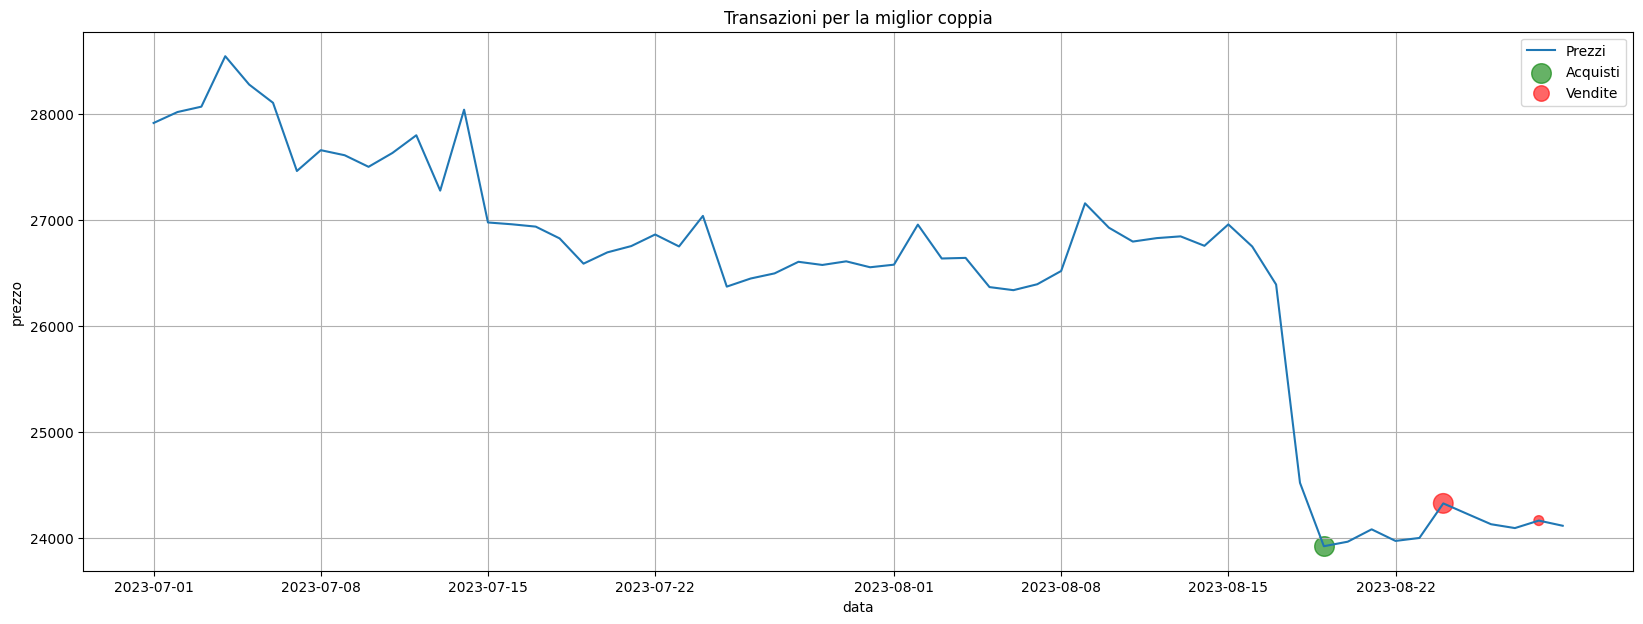


Elenco transazioni per la miglior coppia:


data        prezzo  variazione_giornaliera_prezzo_percentuale  \
48 2023-08-19  23921.724609                                      -2.44   
53 2023-08-24  24326.121094                                       1.36   
57 2023-08-28  24163.882812                                       0.29   

   timestamp_riferimento_discesa  prezzo_riferimento_discesa  \
48                    2023-08-15                26960.865234   
53                           NaT                         NaN   
57                           NaT                         NaN   

    variazione_rispetto_riferimento_discesa timestamp_riferimento_salita  \
48                                   -11.27                          NaT   
53                                      NaN                   2023-08-19   
57                                      NaN                   2023-08-19   

    prezzo_riferimento_salita  variazione_rispetto_riferimento_salita  \
48                        NaN                                     NaN   
53               23921.724609                                    1.69   
57               23921.724609                                    1.01   

      azione  percentuale_liquidità_usata  percentuale_bitcoin_usata  \
48  Acquisto                     0.999979                   0.000000   
53   Vendita                     0.000000                   0.999494   
57   Vendita                     0.000000                   0.999416   

    quantità_euro  bitcoin_acquistati_o_venduti    liquidità   bitcoin  \
48     999.979154                      0.041802     0.020846  0.041802   
53     870.879458                      0.035800   870.900304  0.006002   
57     145.030585                      0.006002  1015.930889  0.000000   

    valore_totale_portafoglio  
48                1000.000000  
53                1016.904636  
57                1015.930889

In [74]:
# Stampa e visualizza i risultati per la coppia migliore
print("\nMiglior coppia:")
print(f"Dataset: {best_pair['dataset']}")
print(f"Parametri: {best_pair['params']}")
print(f"Fattore di rendimento totale: {best_pair['total_return_factor']}")
print(f"Punteggio: {best_pair['score']}")
plot_transactions(dati_da_usare[best_pair['dataset']], best_pair['transactions'], 'Transazioni per la miglior coppia')
print("\nElenco transazioni per la miglior coppia:")
best_pair['transactions'][(best_pair['transactions']['quantità_euro'] > 0)]


Peggior coppia:
Dataset: 66
Parametri: ['inverti_riferimento_acquisto=True', 'inverti_riferimento_vendita=True', 'acquisto_rispetto_liquidità_iniziale=True', 'vendita_rispetto_massimo_btc_posseduti=True', 'compra_pure=True', 'vendi_pure=True', 'soglia_vendita=-0.5', 'A_a=0.1', 'B_a=0.1', 'A_v=0.3', 'B_v=0.1', 'coefficienti_acquisto=custom_exp', 'coefficienti_vendita=custom_exp', 'compra_solo_in_discesa=True', 'vendi_solo_in_salita=False', 'soglia_acquisto_rispetto_riferimento=0.1', 'soglia_vendita_rispetto_riferimento=-0.5', 'soglia_calcolo_variazioni_discesa=0', 'soglia_calcolo_variazioni_salita=0']
Fattore di rendimento totale: 1.0802673732467278
Punteggio: 0.27771425089521307


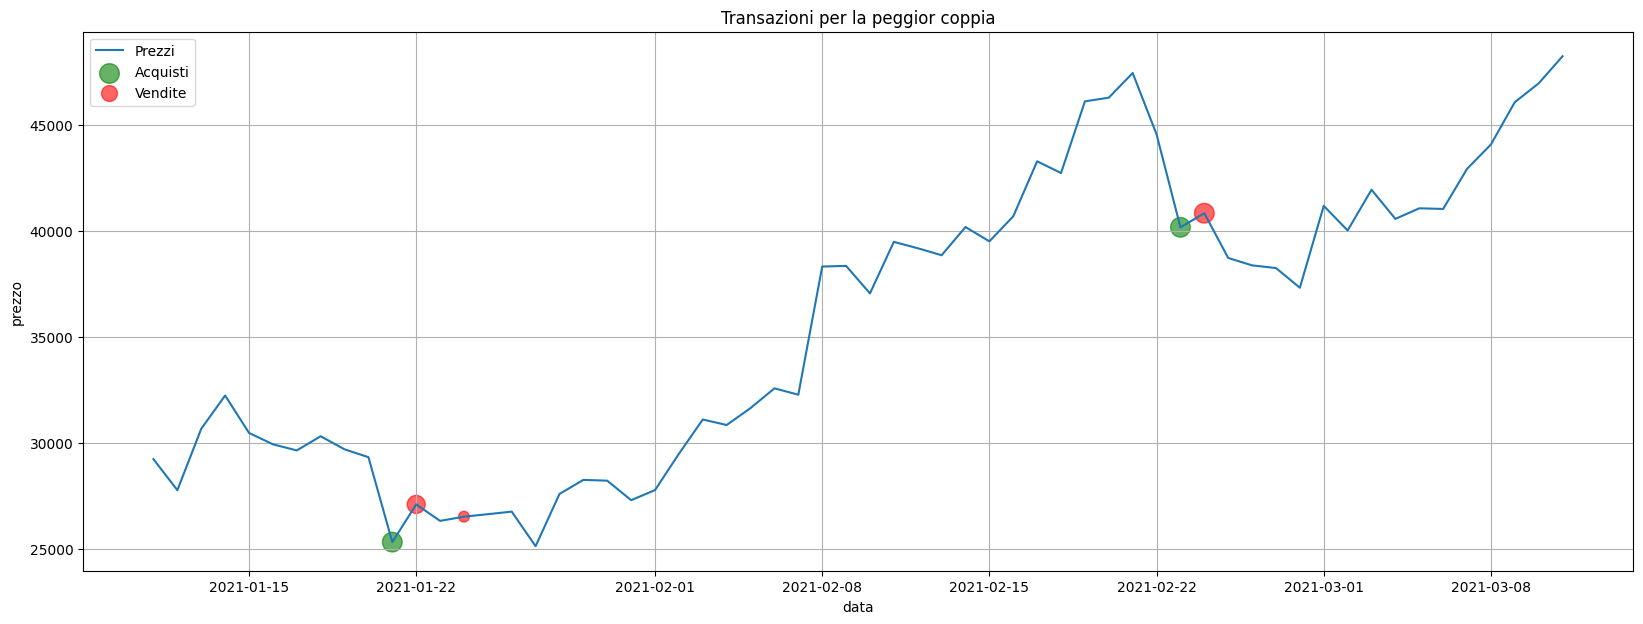


Elenco transazioni per la peggior coppia:


data        prezzo  variazione_giornaliera_prezzo_percentuale  \
9  2021-01-21  25338.507812                                     -13.65   
10 2021-01-22  27116.148438                                       7.02   
12 2021-01-24  26538.091797                                       0.75   
42 2021-02-23  40181.332031                                      -9.83   
43 2021-02-24  40844.414062                                       1.65   

   timestamp_riferimento_discesa  prezzo_riferimento_discesa  \
9                     2021-01-18                30328.933594   
10                           NaT                         NaN   
12                           NaT                         NaN   
42                    2021-02-21                47456.125000   
43                           NaT                         NaN   

    variazione_rispetto_riferimento_discesa timestamp_riferimento_salita  \
9                                    -16.45                          NaT   
10                                      NaN                   2021-01-21   
12                                      NaN                   2021-01-23   
42                                   -15.33                          NaT   
43                                      NaN                   2021-02-23   

    prezzo_riferimento_salita  variazione_rispetto_riferimento_salita  \
9                         NaN                                     NaN   
10               25338.507812                                    7.02   
12               26340.009766                                    0.75   
42                        NaN                                     NaN   
43               40181.332031                                    1.65   

      azione  percentuale_liquidità_usata  percentuale_bitcoin_usata  \
9   Acquisto                     0.982663                   0.000000   
10   Vendita                     0.000000                   0.887727   
12   Vendita                     0.000000                   0.749278   
42  Acquisto                     0.981704                   0.000000   
43   Vendita                     0.000000                   0.803699   

    quantità_euro  bitcoin_acquistati_o_venduti    liquidità   bitcoin  \
9      982.663336                      0.038781    17.336664  0.038781   
10     823.043962                      0.030353   840.380626  0.008429   
12     223.686432                      0.008429  1064.067058  0.000000   
42     981.703927                      0.024432    82.363132  0.024432   
43     997.904242                      0.024432  1080.267373  0.000000   

    valore_totale_portafoglio  
9                 1000.000000  
10                1068.939429  
12                1064.067058  
42                1064.067058  
43                1080.267373

In [75]:
# Stampa e visualizza i risultati per la coppia peggiore
print("\nPeggior coppia:")
print(f"Dataset: {worst_pair['dataset']}")
print(f"Parametri: {worst_pair['params']}")
print(f"Fattore di rendimento totale: {worst_pair['total_return_factor']}")
print(f"Punteggio: {worst_pair['score']}")
plot_transactions(dati_da_usare[worst_pair['dataset']], worst_pair['transactions'], 'Transazioni per la peggior coppia')
print("\nElenco transazioni per la peggior coppia:")
worst_pair['transactions'][(worst_pair['transactions']['quantità_euro'] > 0)]